# Evolution in music through the years

This notebook contains all information about our data processing steps.  

These include data analysis, cleaning, processing, engineering and visualisation.  
For the intermediate milestone we will also provide an updated plan.  

*Due to problem with the cluster only the subset of the data set was analysed locally*  

### Also note that we were a group of 3 students, and that one of the student decided to drop the course the week end of the 25, this can be taken into account for this milestone. Therefore we reduce the scale of our research questions ( by removing 2 of them due to time constraints and not available data on the cluster)

In [1]:
%matplotlib inline

# Provided library to access hdf5 files from MillionSong dataset
import getters as hdf5_getters

# python internal packages
import os
import glob
import re
import time
import math

# default imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, Panel

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# library tested for additional data
#import spotify

# genre simplification
import json
import urllib.request

#ML librairies
from sklearn.utils import resample
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter('ignore', np.RankWarning)

C:\Users\Max-Pc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Fetching 

In [2]:
# Paths for prefetched csv file
local_path = 'millionsong_total.csv'

In [3]:
fetched_df = pd.DataFrame.from_csv(local_path)

# drop unecessary columns
fetched_df = fetched_df.drop(['song_id','artist_mbid', 'artist_familiarity', "artist_similarity"], 1)

fetched_df.columns = ['SongTitle', 'ArtistID', 'ArtistName', 'ArtistLatitude', 'ArtistLongitude', 'ArtistMbtags',\
                      'ArtistTerms', 'ArtistHotness', "SongDanceability", "SongEnergy", "Duration", "SongKey",\
                      "SongLoudness", "SongHotness", "SongTempo", "SongYear", 'SongKeyConfidence', 'SongTimeSignature',\
                      'SongTimeSignatureConfidence', 'ArtistLocation', 'ArtistTermFreq', 'ArtistTermWeight', 'num_songs']

fetched_df.head()

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
C:\Users\Max-Pc\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,SongTitle,ArtistID,ArtistName,ArtistLatitude,ArtistLongitude,ArtistMbtags,ArtistTerms,ArtistHotness,SongDanceability,SongEnergy,...,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,ArtistTermFreq,ArtistTermWeight,num_songs
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAARJ128F9320760,Pink World,AR8ZCNI1187B9A069B,Planet P Project,nan,nan,[],[new wave;progressive rock;space rock;eurodan...,0.332276,0.0,0.0,...,0.265861049211,86.643,1984,0.717,4,0.487,,[0.959766246334;0.97039004532;0.821993419741;...,[1.0;0.986961919746;0.983064531868;0.96580916...,1
TRAAAAK128F9318786,Scream,ARJNIUY12298900C91,Adelitas Way,nan,nan,[],[alternative metal;heavy metal;rock;alternati...,0.461318,0.0,0.0,...,0.733371619962,99.944,2009,0.349,4,0.846,,[0.995874657423;0.995874657423;1.0;0.88565253...,[1.0;0.899353739319;0.756187682886;0.71311746...,1
TRAAAQO12903CD8E1C,Take Time,AR5LMPY1187FB573FE,Chaka Khan_ Rufus,41.88415,-87.63241,[classic pop and rock],[r&b;disco;funk;motown;freestyle;quiet storm;...,0.398984,0.0,0.0,...,0.254279270452,110.325,1978,0.396,4,0.426,Chicago; IL,[0.922730152887;1.0;1.0;0.810682902091;0.8106...,[1.0;0.991539617318;0.925395217966;0.92426646...,1
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,AR73AIO1187B9AD57B,Western Addiction,37.77916,-122.42005,[],[melodic hardcore;skate punk;hardcore punk;ca...,0.386606,0.0,0.0,...,0.481694146614,125.475,2005,0.187,4,0.546,San Francisco; CA,[0.958442007525;0.877423051563;1.0;0.82014263...,[1.0;0.968559809446;0.964753894876;0.86918176...,1
TRAAAUC128F428716F,Drown In My Own Tears (24-Bit Digitally Remas...,ARA23XO1187B9AF18F,The Smithereens,40.57885,-74.21956,[],[pop rock;alternative rock;power pop;indie ro...,0.405015,0.0,0.0,...,nan,123.756,0,0.931,4,0.494,Carteret; New Jersey,[0.980739660227;0.984358036619;0.898633143514...,[1.0;0.948729939236;0.947882309562;0.91553730...,1


In [4]:
fetched_df['num_songs'].mean()

1.0

In [5]:
df = fetched_df.copy()
print ("The dataframe contains {} songs".format(df.shape[0]))

The dataframe contains 462546 songs


## Data Analysis and Cleaing

Since we want to analyze music evolution over time, we cannot use Songs without specified year. They are then dropped.

In [6]:
print("Dropping {} rows.".format(df[df['SongYear'] == 0].shape[0]))
df = df[df['SongYear']>0]

Dropping 223821 rows.


In [7]:
df.head()

,SongTitle,ArtistID,ArtistName,ArtistLatitude,ArtistLongitude,ArtistMbtags,ArtistTerms,ArtistHotness,SongDanceability,SongEnergy,...,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,ArtistTermFreq,ArtistTermWeight,num_songs
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAARJ128F9320760,Pink World,AR8ZCNI1187B9A069B,Planet P Project,nan,nan,[],[new wave;progressive rock;space rock;eurodan...,0.332276,0.0,0.0,...,0.265861049211,86.643,1984,0.717,4,0.487,,[0.959766246334;0.97039004532;0.821993419741;...,[1.0;0.986961919746;0.983064531868;0.96580916...,1
TRAAAAK128F9318786,Scream,ARJNIUY12298900C91,Adelitas Way,nan,nan,[],[alternative metal;heavy metal;rock;alternati...,0.461318,0.0,0.0,...,0.733371619962,99.944,2009,0.349,4,0.846,,[0.995874657423;0.995874657423;1.0;0.88565253...,[1.0;0.899353739319;0.756187682886;0.71311746...,1
TRAAAQO12903CD8E1C,Take Time,AR5LMPY1187FB573FE,Chaka Khan_ Rufus,41.88415,-87.63241,[classic pop and rock],[r&b;disco;funk;motown;freestyle;quiet storm;...,0.398984,0.0,0.0,...,0.254279270452,110.325,1978,0.396,4,0.426,Chicago; IL,[0.922730152887;1.0;1.0;0.810682902091;0.8106...,[1.0;0.991539617318;0.925395217966;0.92426646...,1
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,AR73AIO1187B9AD57B,Western Addiction,37.77916,-122.42005,[],[melodic hardcore;skate punk;hardcore punk;ca...,0.386606,0.0,0.0,...,0.481694146614,125.475,2005,0.187,4,0.546,San Francisco; CA,[0.958442007525;0.877423051563;1.0;0.82014263...,[1.0;0.968559809446;0.964753894876;0.86918176...,1
TRAAAUR128F428B1FA,Smash It Up,AR0MWD61187B9B2B12,International Noise Conspiracy,nan,nan,[],[ska punk;garage rock;post-hardcore;garage pu...,0.414283,0.0,0.0,...,0.767828738594,148.957,2000,0.451,4,0.144,,[0.884642893649;0.905262621301;0.905262621301...,[1.0;0.972876260864;0.96844862128;0.958751376...,1


In [8]:
df = df.replace(' nan', np.NAN)
df.isnull().sum()

SongTitle                           0
ArtistID                            0
ArtistName                          0
ArtistLatitude                 152586
ArtistLongitude                152586
ArtistMbtags                        0
ArtistTerms                         0
ArtistHotness                       2
SongDanceability                    0
SongEnergy                          0
Duration                            0
SongKey                             0
SongLoudness                        0
SongHotness                     79295
SongTempo                           0
SongYear                            0
SongKeyConfidence                   0
SongTimeSignature                   0
SongTimeSignatureConfidence         0
ArtistLocation                      0
ArtistTermFreq                      0
ArtistTermWeight                    0
num_songs                           0
dtype: int64

In [9]:
# convert numeric
df["SongHotness"] = pd.to_numeric(df["SongHotness"])
df["ArtistLatitude"] = pd.to_numeric(df["ArtistLatitude"])
df["ArtistLongitude"] = pd.to_numeric(df["ArtistLongitude"])
df["ArtistHotness"] = pd.to_numeric(df["ArtistHotness"])

In [10]:
# Create an additional data frame which improves machine learning algorithms
normalized_df = df.copy()

We notice, that 1616/4680 Songs do not have a defined Hotness.  
Furthermore, the Latitude and Longitude of the arists for 2855 Songs is not defined.  
For now we will keep the features and rows with NAN, and we will remove them if it would be neccessary to take the NANs into account.  
Let's have a deeper look at the different columns:

In [11]:
df.describe()

,ArtistLatitude,ArtistLongitude,ArtistHotness,SongDanceability,SongEnergy,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,num_songs
count,86139.000000,86139.000000,238723.000000,238725.0,238725.0,238725.000000,238725.000000,238725.000000,159430.000000,238725.000000,238725.000000,238725.000000,238725.000000,238725.000000,238725.0
mean,39.954701,-54.343646,0.416746,0.0,0.0,246.448487,5.314722,-9.703421,0.430871,124.792726,1998.372902,0.442804,3.614058,0.516758,1.0
std,15.665472,56.055263,0.108956,0.0,0.0,115.210594,3.598526,4.947483,0.214409,34.896554,10.940322,0.276260,1.205529,0.370947,0.0
min,-51.800580,-159.540540,0.000000,0.0,0.0,0.313020,0.000000,-57.004000,0.000000,0.000000,1922.000000,0.000000,0.000000,0.000000,1.0
25%,35.090810,-90.180490,0.364340,0.0,0.0,182.987300,2.000000,-12.193000,0.304170,98.992000,1994.000000,0.214000,3.000000,0.130000,1.0
50%,40.714550,-75.162370,0.410039,0.0,0.0,229.824850,5.000000,-8.619000,0.459158,122.568000,2002.000000,0.462000,4.000000,0.558000,1.0
75%,50.875660,-1.509510,0.469826,0.0,0.0,286.667300,9.000000,-6.126000,0.581318,145.245000,2006.000000,0.653000,4.000000,0.868000,1.0
max,70.695760,175.471310,1.082503,0.0,0.0,3024.665670,11.000000,3.634000,1.000000,275.393000,2011.000000,1.000000,7.000000,1.000000,1.0


By analysing the descriptive statistics of each columns we gained the following insights:

|         |        ArtistID       | ArtistName         |         SongYear        | SongDanceability |       Duration      |   SongHotness   | SongTitle |  SongTempo |    SongTimeSignature   |      SongTimeSignatureConfidence      |                 ArtistMbtags                |                      ArtistTerms                     | ArtistLocation |  ArtistLatitude  |  ArtistLongitude  | SongKey                                                                  | SongKeyConfidence                    | SongEnergy | SongLoudness |   ArtistHotness
|:-------:|:---------------------:|--------------------|:-----------------------:|:----------------:|:-------------------:|:---------------:|:---------:|:----------:|:----------------------:|:-------------------------------------:|:-------------------------------------------:|:----------------------------------------------------:|:--------------:|:----------------:|:-----------------:|--------------------------------------------------------------------------|--------------------------------------|------------|--------------|--------------|
|  format |         string        |       string       |           int           |       float      |        float        |      float      |   string  |    float   |           int          |                 float                 |                    string                   |                        string                        |     string     |       float      |       float       |                                    int                                   |                 float                |    float   |     float    |     float  |
|   type  |       categorial      |     categorial     |        continious       |    continious    |      continious     |    continious   |     -     | continious |         Ordinal        |               continious              |                                             |                                                      |                |    continious    |     continious    |                                  Ordinal                                 |              continious              |            |   continous  |      continous       |
| comment | identifier for artist | name of the Artist | years from 1926 to 2010 |     always 0     | duration in seconds | between 0 and 1 |           |            | values between 0 and 7 | between 0 and 1, 1 is very confident  | comma seperated array with mbtags of artist | comma seperated array with echo nest terms of artist |   town, state  | default latitude | default longitude | 0-11 for [c, c-sharp, d, e-flat, e, f, f-sharp, g, a-flat, a, b-flat, b] | between 0 and 1, 1 is very confident | always 0   |  -51 to 0.5  |  between 0 and 1 

Now that we know a little bit more about the different features, let's have a deeper look at their distribution.

### Song Year

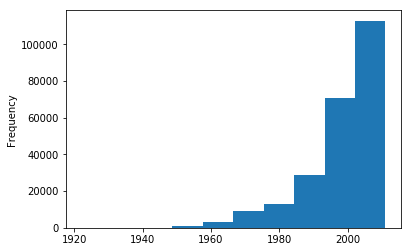

In [12]:
df.SongYear.plot(kind='hist')

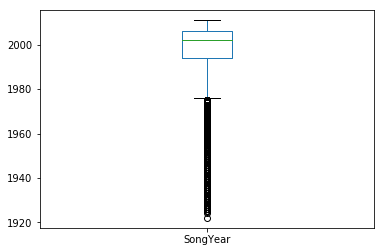

In [13]:
df.SongYear.plot.box()

The distribution of the year feature is negatively skewed.  
The available years span from 1926 to 2010.  
It makes sense to normalize the feature with scaling.
Normalize the year first

In [14]:
normalized_df["SongYearNorm"] = (df.SongYear-df.SongYear.min())/ \
                            (df.SongYear.max()-df.SongYear.min())
normalized_df.head()

,SongTitle,ArtistID,ArtistName,ArtistLatitude,ArtistLongitude,ArtistMbtags,ArtistTerms,ArtistHotness,SongDanceability,SongEnergy,...,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,ArtistTermFreq,ArtistTermWeight,num_songs,SongYearNorm
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAARJ128F9320760,Pink World,AR8ZCNI1187B9A069B,Planet P Project,NaN,NaN,[],[new wave;progressive rock;space rock;eurodan...,0.332276,0.0,0.0,...,86.643,1984,0.717,4,0.487,,[0.959766246334;0.97039004532;0.821993419741;...,[1.0;0.986961919746;0.983064531868;0.96580916...,1,0.696629
TRAAAAK128F9318786,Scream,ARJNIUY12298900C91,Adelitas Way,NaN,NaN,[],[alternative metal;heavy metal;rock;alternati...,0.461318,0.0,0.0,...,99.944,2009,0.349,4,0.846,,[0.995874657423;0.995874657423;1.0;0.88565253...,[1.0;0.899353739319;0.756187682886;0.71311746...,1,0.977528
TRAAAQO12903CD8E1C,Take Time,AR5LMPY1187FB573FE,Chaka Khan_ Rufus,41.88415,-87.63241,[classic pop and rock],[r&b;disco;funk;motown;freestyle;quiet storm;...,0.398984,0.0,0.0,...,110.325,1978,0.396,4,0.426,Chicago; IL,[0.922730152887;1.0;1.0;0.810682902091;0.8106...,[1.0;0.991539617318;0.925395217966;0.92426646...,1,0.629213
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,AR73AIO1187B9AD57B,Western Addiction,37.77916,-122.42005,[],[melodic hardcore;skate punk;hardcore punk;ca...,0.386606,0.0,0.0,...,125.475,2005,0.187,4,0.546,San Francisco; CA,[0.958442007525;0.877423051563;1.0;0.82014263...,[1.0;0.968559809446;0.964753894876;0.86918176...,1,0.932584
TRAAAUR128F428B1FA,Smash It Up,AR0MWD61187B9B2B12,International Noise Conspiracy,NaN,NaN,[],[ska punk;garage rock;post-hardcore;garage pu...,0.414283,0.0,0.0,...,148.957,2000,0.451,4,0.144,,[0.884642893649;0.905262621301;0.905262621301...,[1.0;0.972876260864;0.96844862128;0.958751376...,1,0.876404


### Song Danceability

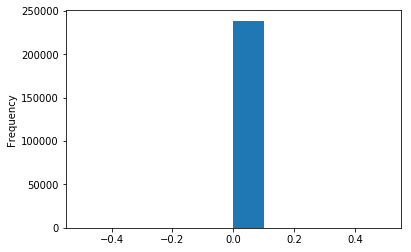

In [15]:
df.SongDanceability.plot(kind='hist')

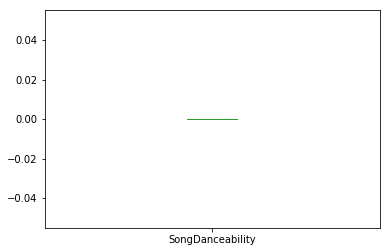

In [16]:
df.SongDanceability.plot.box()

All songs of our cleaned data frame has danceability `0`.  
Therefore we will drop this column.  

In [17]:
normalized_df.drop(labels=['SongDanceability'], axis=1, inplace=True)

### Duration

(6130, 23)
(8525, 23)


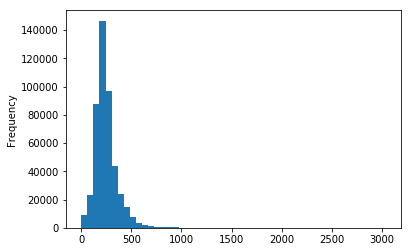

In [9]:
df.Duration.plot(kind='hist',bins=50)
print(df[df['Duration']>600].shape)
print(df[df['Duration']<60].shape)

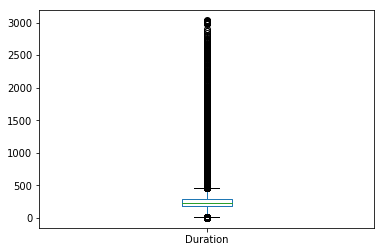

In [10]:
df.Duration.plot.box()

We can see in the histogram, that most of the songs duration are normal distributed.  
However, there are outliers with song durations over 10 minutes and under 60 seconds.   
In our normalized DataFrame we remove the outliers for the duration, since they might deviate too much from the average songs, which we want to analyse.

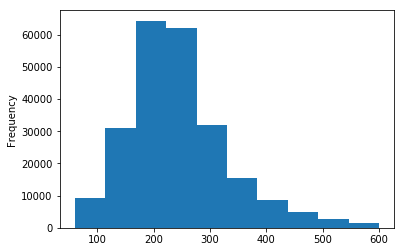

In [20]:
normalized_df = normalized_df[normalized_df['Duration']>60]
normalized_df = normalized_df[normalized_df['Duration']<600]
normalized_df.Duration.plot(kind='hist')


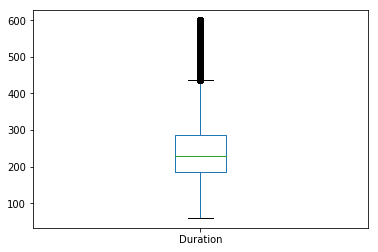

In [21]:
normalized_df.Duration.plot.box()

### Song Hotness

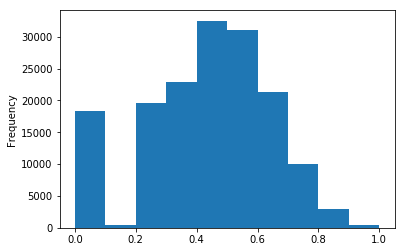

In [22]:
df.SongHotness.plot(kind='hist')

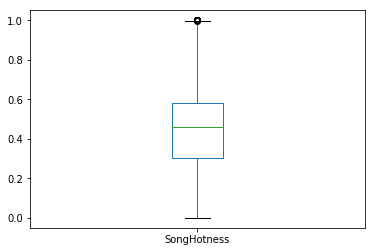

In [23]:
df.SongHotness.plot.box()

The distribution of the Hotness is not skewed.  
There are a few songs where the hotness is missing.  
When analysing hotness remove songs with hotness of zero. But for now we will keep the songs for other analysis tasks.

### Song Tempo 

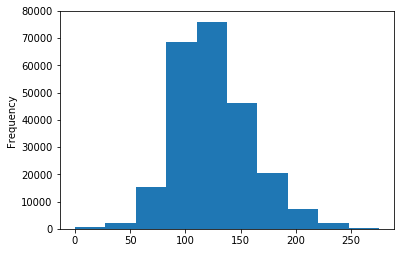

In [24]:
df.SongTempo.plot(kind='hist')

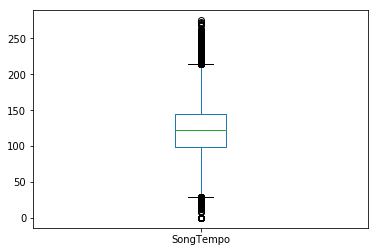

In [25]:
df.SongTempo.plot.box()

The distribution of the tempo is normal. There are some outliers with a very high or low tempo of more than 200 or less than 25.  
We will remove these outliers, since they might deviate from the average songs we want to analyse.

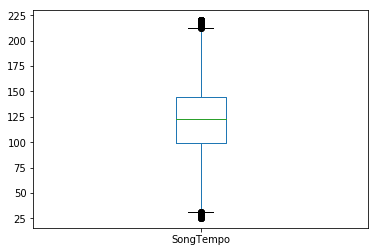

In [26]:
normalized_df = normalized_df[normalized_df['SongTempo']<220]
normalized_df = normalized_df[normalized_df['SongTempo']>25]
normalized_df.SongTempo.plot.box()

### Song Time Signature

The Song Time Signature describes the number of beats per bar.

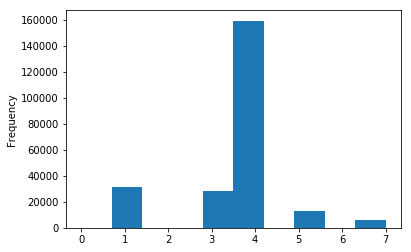

In [27]:
df.SongTimeSignature.plot(kind='hist')

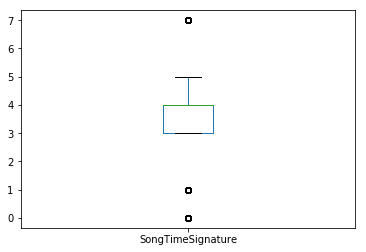

In [28]:
df.SongTimeSignature.plot.box()

The distribution of the Time signature also looks normally distributed, without many outliers.  
Therefore we will keep the feature as it is.

### Song Time Signature Confidence

The Song Time Signature Confidence describes the confidence in the Song Time Signature. It is 1 when the Song Time Signature is very accurate and 0 if is unknown.

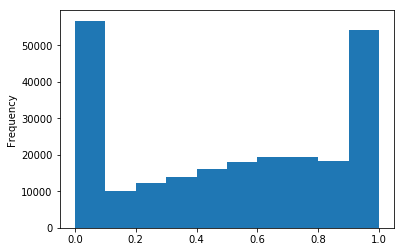

In [29]:
df.SongTimeSignatureConfidence.plot(kind='hist')

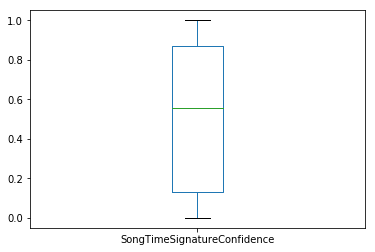

In [30]:
df.SongTimeSignatureConfidence.plot.box()

The majority of songs has either 0 or 1 as confidence. The other confidences are almost equally distributed.    
When analysing TimeSignature we will remove songs with low confidence, but keep the songs for now.

### Artist Location

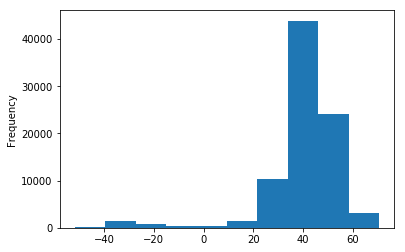

In [31]:
df.ArtistLatitude.plot(kind='hist')

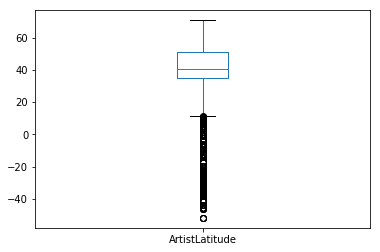

In [32]:
df.ArtistLatitude.plot.box()

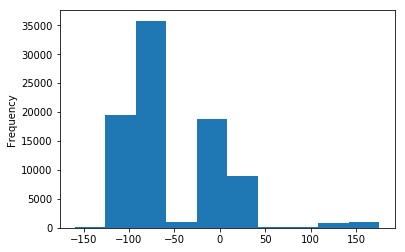

In [33]:
df.ArtistLongitude.plot(kind='hist')

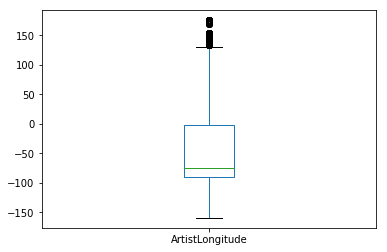

In [34]:
df.ArtistLongitude.plot.box()

We will keep the artist locations for now as they are, since we wanted to look at the correlation between different song types and artist locations.

### Song Key

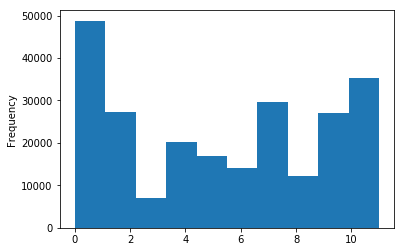

In [35]:
df.SongKey.plot(kind='hist')

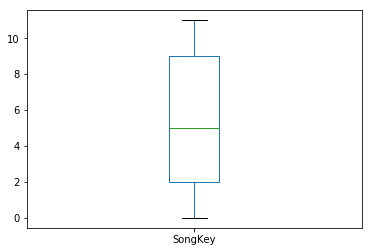

In [36]:
df.SongKey.plot.box()

The key feature has no clear distribution. It contains several peaks which might come from several joined normal distributions for each genre.  
The distribution will be reanalysed for each genre.

### Song Key Confidence

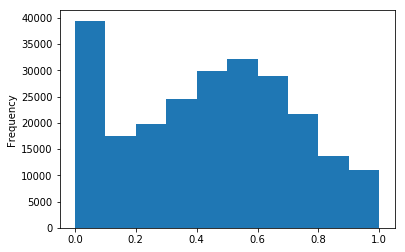

In [37]:
df.SongKeyConfidence.plot(kind='hist')

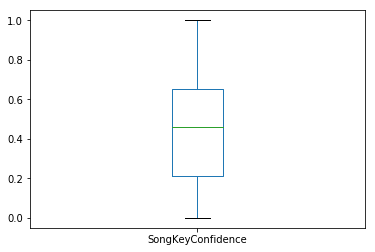

In [38]:
df.SongKeyConfidence.plot.box()

The Song Key Confidence describes the confidence in the Song Key. It is 1 when the Song Key is very accurate and 0 if is unknown.  
The confidence level is not too low, when analysing the key we will remove the songs with low confidence.

### Song Energy

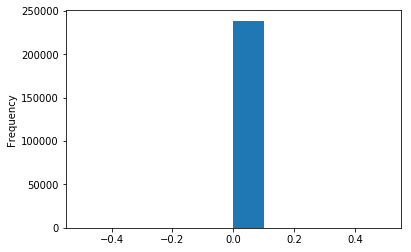

In [39]:
df.SongEnergy.plot(kind='hist')

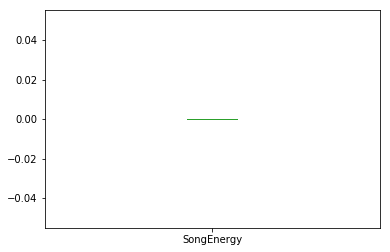

In [40]:
df.SongEnergy.plot.box()

All songs of our cleaned data frame has energy `0`.  
Therefore we will drop this column.  

In [41]:
normalized_df.drop(labels=['SongEnergy'], axis=1, inplace=True)

### Song Loudness

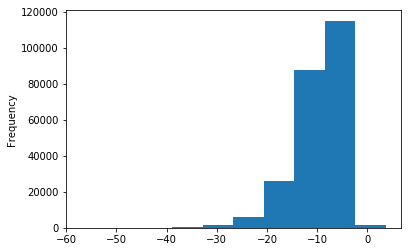

In [42]:
df.SongLoudness.plot(kind='hist')

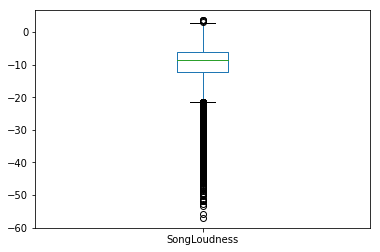

In [43]:
df.SongLoudness.plot.box()

We notice that the loudness is negatively skewed. This means there are a few songs which are really silent.  
We will remove those songs since they deviate from the average song, which we want to analyse.

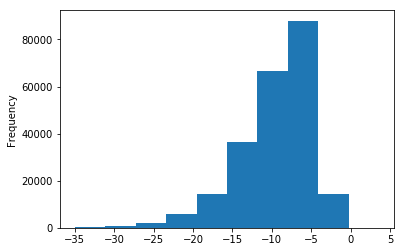

In [44]:
normalized_df = normalized_df[normalized_df['SongLoudness']>-35]
normalized_df.SongLoudness.plot(kind='hist')

### Artist Hotness

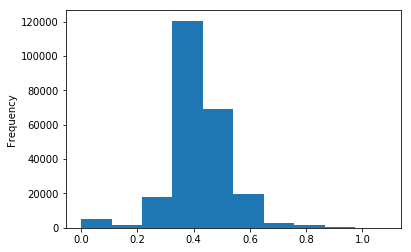

In [45]:
df.ArtistHotness.plot(kind='hist')

We notice that the hotness is also gaussian, with a bigger weight on the right side ( which is nice for us ), and very few datas on the left side.

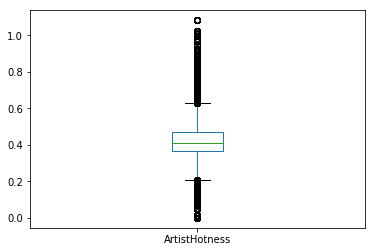

In [46]:
df.ArtistHotness.plot.box()

We will keep this hotness that can be rerally useful for our analysis coupled to other data or to help the clustering of song

## Feature Processing

Beside the numeric features, the data frame also contains features with strings.
Actually all String are bytes string so we will transform them into `str` for better comparison. The concerned features are ArtistName, ArtistLocation, SongTitle, ArtistID and tag from the arrays.

*The preprocessed file already resolved that, we only need to turn ; into , for the string specifing a list and convert them into a list*

In [47]:
def transform(x):
    if (len(x.strip()) > 2):
        genres_string = x.replace(';','","')
        genres_string = genres_string.replace('[','["')
        genres_string = genres_string.replace(']','"]')
        genres = json.loads(genres_string)
        return genres
    else:
        return []

In [48]:
normalized_df.ArtistMbtags = df.ArtistMbtags.apply(lambda row : transform(row))
normalized_df.ArtistTerms = df.ArtistTerms.apply(lambda row : transform(row))

normalized_df.ArtistTermFreq = df.ArtistTermFreq.apply(lambda row : transform(row))
normalized_df.ArtistTermWeight = df.ArtistTermWeight.apply(lambda row : transform(row))

normalized_df.head()

,SongTitle,ArtistID,ArtistName,ArtistLatitude,ArtistLongitude,ArtistMbtags,ArtistTerms,ArtistHotness,Duration,SongKey,...,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,ArtistTermFreq,ArtistTermWeight,num_songs,SongYearNorm
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAARJ128F9320760,Pink World,AR8ZCNI1187B9A069B,Planet P Project,NaN,NaN,[],"[new wave, progressive rock, space rock, eurod...",0.332276,269.81832,4,...,86.643,1984,0.717,4,0.487,,"[0.959766246334, 0.97039004532, 0.821993419741...","[1.0, 0.986961919746, 0.983064531868, 0.965809...",1,0.696629
TRAAAAK128F9318786,Scream,ARJNIUY12298900C91,Adelitas Way,NaN,NaN,[],"[alternative metal, heavy metal, rock, alterna...",0.461318,213.94240,1,...,99.944,2009,0.349,4,0.846,,"[0.995874657423, 0.995874657423, 1.0, 0.885652...","[1.0, 0.899353739319, 0.756187682886, 0.713117...",1,0.977528
TRAAAQO12903CD8E1C,Take Time,AR5LMPY1187FB573FE,Chaka Khan_ Rufus,41.88415,-87.63241,[classic pop and rock],"[r&b, disco, funk, motown, freestyle, quiet st...",0.398984,258.89914,1,...,110.325,1978,0.396,4,0.426,Chicago; IL,"[0.922730152887, 1.0, 1.0, 0.810682902091, 0.8...","[1.0, 0.991539617318, 0.925395217966, 0.924266...",1,0.629213
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,AR73AIO1187B9AD57B,Western Addiction,37.77916,-122.42005,[],"[melodic hardcore, skate punk, hardcore punk, ...",0.386606,118.07302,7,...,125.475,2005,0.187,4,0.546,San Francisco; CA,"[0.958442007525, 0.877423051563, 1.0, 0.820142...","[1.0, 0.968559809446, 0.964753894876, 0.869181...",1,0.932584
TRAAAUR128F428B1FA,Smash It Up,AR0MWD61187B9B2B12,International Noise Conspiracy,NaN,NaN,[],"[ska punk, garage rock, post-hardcore, garage ...",0.414283,195.39546,0,...,148.957,2000,0.451,4,0.144,,"[0.884642893649, 0.905262621301, 0.90526262130...","[1.0, 0.972876260864, 0.96844862128, 0.9587513...",1,0.876404


## Data Correlation

For the correlation we will focus on the rows with a high confidence measure.

In [49]:
corr_df = normalized_df.copy()
#corr_df = corr_df[normalized_df['SongTimeSignatureConfidence']>0.5]
#corr_df = corr_df[normalized_df['SongKeyConfidence']>0.5]

In [50]:
corr = corr_df.corr()
corr

,ArtistLatitude,ArtistLongitude,ArtistHotness,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,num_songs,SongYearNorm
ArtistLatitude,1.000000,0.001269,0.035870,0.045247,-0.000960,0.034986,0.061167,0.005521,0.021979,-0.012478,0.014663,0.019332,NaN,0.021979
ArtistLongitude,0.001269,1.000000,0.011421,0.092301,0.002564,0.061122,0.019787,0.008305,0.079290,-0.016553,0.043088,0.035029,NaN,0.079290
ArtistHotness,0.035870,0.011421,1.000000,0.003525,-0.000435,0.110915,0.459441,0.003813,-0.004288,0.012836,0.026086,0.023284,NaN,-0.004288
Duration,0.045247,0.092301,0.003525,1.000000,0.024474,0.024455,-0.006349,-0.020422,0.083953,0.014551,0.123061,0.121310,NaN,0.083953
SongKey,-0.000960,0.002564,-0.000435,0.024474,1.000000,0.029679,-0.000263,0.013636,0.013304,-0.044761,0.012987,0.005154,NaN,0.013304
SongLoudness,0.034986,0.061122,0.110915,0.024455,0.029679,1.000000,0.154985,0.172920,0.294106,-0.014671,0.087562,0.011067,NaN,0.294106
SongHotness,0.061167,0.019787,0.459441,-0.006349,-0.000263,0.154985,1.000000,0.025321,0.101076,-0.001374,0.022734,0.017804,NaN,0.101076
SongTempo,0.005521,0.008305,0.003813,-0.020422,0.013636,0.172920,0.025321,1.000000,0.016362,0.044078,0.024283,-0.172270,NaN,0.016362
SongYear,0.021979,0.079290,-0.004288,0.083953,0.013304,0.294106,0.101076,0.016362,1.000000,-0.043447,0.090996,0.110984,NaN,1.000000
SongKeyConfidence,-0.012478,-0.016553,0.012836,0.014551,-0.044761,-0.014671,-0.001374,0.044078,-0.043447,1.000000,-0.087350,-0.048084,NaN,-0.043447


We seem to have very few correlated features, so we will try to analyze by doing some more analysis on different paramters and doing some feature engineering.  

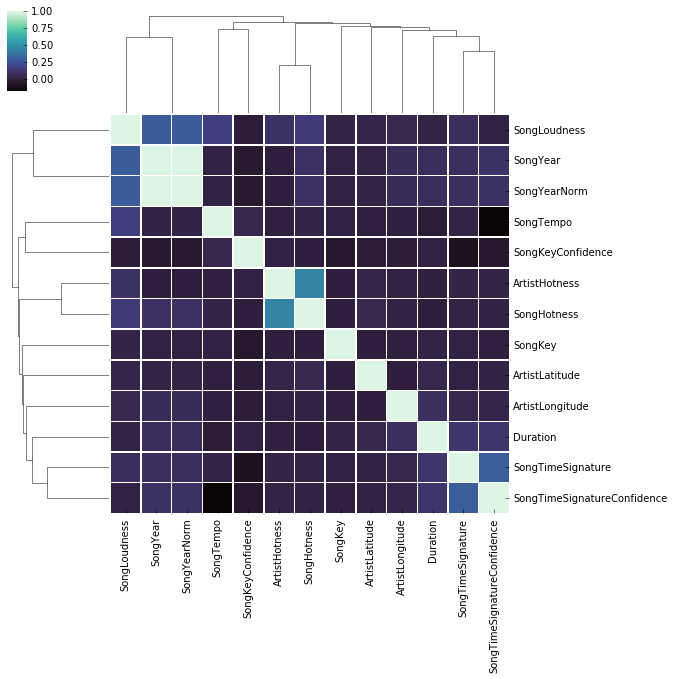

In [56]:
corrSns = corr
corrSns = corrSns.dropna(axis=1,how='all')
corrSns = corrSns.dropna(axis=0,how='all')
cg = sns.clustermap(corrSns, linewidth=.5, figsize=(9,9),cmap='mako')
plt.setp(cg)

The most correlated features are SongYear and SongLoudness, SongHotness and SongLoudness, and SongHotness and SongYear.  
The correlation between Hotness and Year exists, since the hotness value is only a snapshot of the hotness in 2010.  
But there seems to be a trend for Loudness over the years, correlated with Hotness for Song and artist

## Further dependencies

### Preprocessing

Since we want to analyse the change over time and the time feature is very unbalanced, we will resample our data to a equally distributed time feature.

In [52]:
def resample_df(df):

    classes = [0,1950,1960,1970,1980,1990,2000,2010,2015]
    df_classes = [] # df containing the rows of each class
    for i in range(1,len(classes)-1):
        df_classes.append(df[np.logical_and(df.SongYear > classes[i-1], \
                                     df.SongYear < classes[i+1])])

    # print shapes for overview
    for i in range(len(df_classes)):
        print (df_classes[i].shape)

    # resample dataframes with replacement in order to aquire the same number of tracks per class
    for i in range(len(df_classes)-1):
        df_classes[i] = resample(df_classes[i], replace=True, n_samples=128053, random_state=42)

    # merge the data frames
    resampled_df = df_classes[0]
    for i in range(1,len(df_classes)):
        resampled_df = pd.concat([resampled_df, df_classes[i]])
    return resampled_df

In [53]:
resampled_df = resample_df(normalized_df)


(1809, 22)
(6646, 22)
(16198, 22)
(29025, 22)
(72847, 22)
(184485, 22)
(128053, 22)


Let's see if we can find correlations which can e.g. not be found by the pearson coefficient:

### Correlation for Song Year

In [54]:
def print_time_statistics(df):
    x = df.SongYear
    y = df.SongHotness
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Song Hotness")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.ArtistHotness
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=25, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.01, ymax + 0.01])
    ax.set_title("Hexagon binning Year, Artist Hotness")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.Duration
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Duration")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.SongLoudness
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Loudness")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

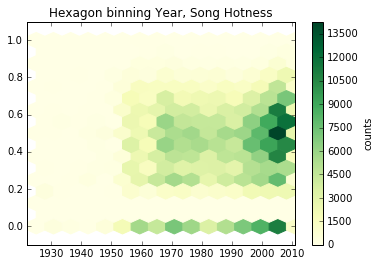

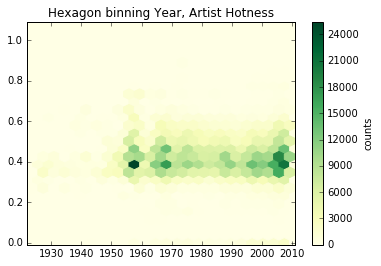

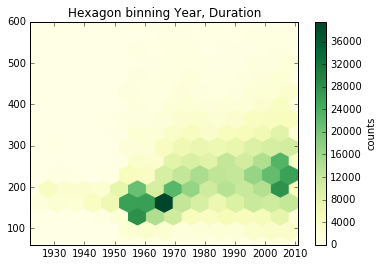

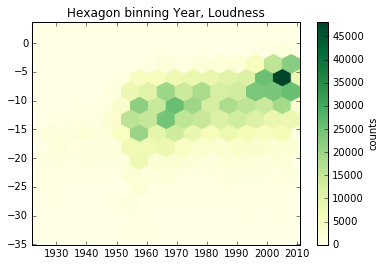

In [55]:
print_time_statistics(resampled_df)

We can indeed see that the majority of the song we have  with a hotness > 0 are song from the 2000's, and there is a general evolution through our data, old song have few hotness > 0, and the more we go to 2010, the more song we have with a hotness >0

For artist hotness, it is actually different, we have almost no artist that have a 0 hotness, and artist in the 200s have a lot of hotness, but we seems to have more artist that released song from 1990-2000s. This might be a problem due to the distribution of artist from song. An artist might have lot of song released in different period (around 5-6 years)

The evolution of duration has not change this much, the duration seems to be quite similar through the years

### Interest about Artist and released Songs

Here there is an interesting correlation between years and loudness, it seems that song from nowadays are louder than the one from 20 or 30 years ago

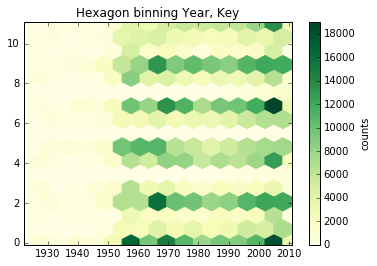

In [56]:
x = resampled_df.SongYear
y = resampled_df.SongKey
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Key")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

In [57]:
def inSet(setC,x):
    """
    Appends x to the set of it is not yet included
    """
    if(x not in setC):
        setC.append(x)

In [58]:
distinctName = []
# create set for artists
normalized_df.ArtistName.apply(lambda x : inSet(distinctName,x))
print (len(distinctName))

# Create data frame for artists
artistDF = pd.DataFrame(distinctName,columns=['ArtistName'])
artistDF.head()

30001


,ArtistName
0,Planet P Project
1,Adelitas Way
2,Chaka Khan_ Rufus
3,Western Addiction
4,International Noise Conspiracy


In [59]:
songNumber = []
songYear = []

# fetch song release years of artist
for x in distinctName:
    test = normalized_df[normalized_df.ArtistName==x]['SongYear']
    songNumber.append(len(test))
    songYear.append(test.values)

# Extend data frame
artistDF['NumberSong']= songNumber
artistDF['SongsYear'] = songYear
artistDF['StdYear'] = artistDF.SongsYear.apply(lambda x : np.std(x))

KeyboardInterrupt: 

In [51]:
artistDF.head()

NameError: name 'artistDF' is not defined

In [ ]:
artistDF.NumberSong.plot(kind='hist')

In [ ]:
artistDF.StdYear.plot(kind='hist',bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20])

We see that the distribution of song from artist is positively skewed. Also some artist have really high standard deviation for song release ( more than 5 years ) which can be interesting for evolution of the same artist, to see if he released a popular song after an already popular one or the contrary what makes the popularity change in 2 of its song

### Other Correlations

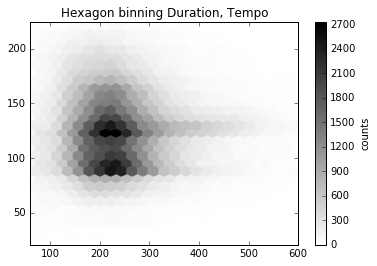

In [60]:
x = normalized_df.Duration
y = normalized_df.SongTempo
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=25, cmap="gist_yarg")
ax.axis([xmin, xmax, ymin - 5, ymax + 5])
ax.set_title("Hexagon binning Duration, Tempo")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

As said previously, the duration and tempo of songs are quite clustered between [120-300] seconds and [90-160] BPM

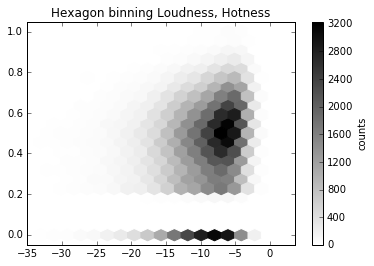

In [61]:
x = normalized_df.SongLoudness
y = normalized_df.SongHotness
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=20, cmap="gist_yarg")
ax.axis([xmin, xmax, ymin - 0.05, ymax + 0.05])
ax.set_title("Hexagon binning Loudness, Hotness")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

We can see that most of the song are located in range 90-150 in BPM with duration between 120 - 300 seconds.  


We can't do much more correlation analysis as few datas are correlated and we have a small subset so this is likely to change with a full dataset.

In [62]:
df.ArtistTerms.head()

track_id
TRAAARJ128F9320760     [new wave;progressive rock;space rock;eurodan...
TRAAAAK128F9318786     [alternative metal;heavy metal;rock;alternati...
TRAAAQO12903CD8E1C     [r&b;disco;funk;motown;freestyle;quiet storm;...
TRAAAAV128F421A322     [melodic hardcore;skate punk;hardcore punk;ca...
TRAAAUR128F428B1FA     [ska punk;garage rock;post-hardcore;garage pu...
Name: ArtistTerms, dtype: object

In [63]:
df.ArtistMbtags.head()

track_id
TRAAARJ128F9320760                         []
TRAAAAK128F9318786                         []
TRAAAQO12903CD8E1C     [classic pop and rock]
TRAAAAV128F421A322                         []
TRAAAUR128F428B1FA                         []
Name: ArtistMbtags, dtype: object

Here we can see that the term of MbTags are more generic and some do not have any tags, while the tags from Terms are really variate.  
We will further elaborate the genres in the next chapter.

## Feature Engineering

Since we only have the genres for the artist and not for the songs, the deviation of genres per artist is quite high (up to 200 genres per artist). In order to clean the genres per artist let's have a look at the genre frequency distribution.

In [7]:
freqs = np.array(np.concatenate(normalized_df['ArtistTermFreq']))
freqs = np.ravel(freqs).astype(float)
plt.hist(freqs)

NameError: name 'normalized_df' is not defined

Let's remove all terms with frequencies lower than 0.6.

In [ ]:
iter = 0
for index, row in normalized_df.iterrows():
    if iter % 10000 == 0:
        print (index)        
    iter += 1
    terms = np.asarray(normalized_df.loc[index, 'ArtistTerms'])
    freqs = np.asarray(normalized_df.loc[index, 'ArtistTermFreq']).astype(float)
        
    index_keep = np.where(freqs > 0.6)
    normalized_df.loc[index, 'ArtistTerms'] = json.dumps(np.take(terms, index_keep).tolist())
    normalized_df.loc[index, 'ArtistTermFreq'] = json.dumps(np.take(freqs, index_keep).tolist())
    

In [ ]:
normalized_df.to_pickle("millionsong_total_genre_reduced.pkl")

In [7]:
normalized_df = pd.read_pickle("millionsong_total_genre_reduced.pkl")
normalized_df.ArtistTerms = normalized_df.ArtistTerms.apply(lambda x : np.array(json.loads(x)).squeeze())

The amout of different genres is too high. We want to reduce the number of genres.  
Therefore we reduce the genres with an obtained json tree structure from http://musicmap.info/.

In [8]:
"""
Reduce the genres to a main genre using the provided json file
"""
# Main genres
maingenre = ['inl','met','rnr','gld','pwv','hcp','alt','con','pop','cou','rnb','gos','blu','jaz','jam','rap','brb','dnb','hct','tec','hou','tra','dtp']

genreTree = {}
with urllib.request.urlopen('http://musicmap.info/master-genrelist.json') as url:
    data = json.loads(url.read().decode())
    
    # check the first level
    for x in maingenre: 
        name = data.get(x).get('name')
        
        # clean data
        genreName = name.replace('<span class=\'subtitle\'>','')
        genreName = genreName.replace('</span>','')
        genreName = genreName.replace(' \'N\'',' N')
        
        # find genres
        genreNames = re.findall(r'([A-Z]+\s+\'+[A-Z+\'+\s]*|[A-Z+\s+\-]+)',data.get(x).get('name'))
        for g in genreNames:
            if(len(g)>1):
                # add to map
                genreTree[g.replace(' ', '')] = genreName
                
        # check the second level
        for subgenreEntry in data.get(x)["genrelist"]:
            
            # clean data
            subgenres = re.sub(r"<a.*'>", "", subgenreEntry)
            subgenres = re.sub(r'</a>', "", subgenres)
            subgenres = subgenres.replace('&amp','and')
            subgenres = subgenres.replace(' \'N\'',' N')
            
            # find genres
            subgenres = subgenres.split('/')
            for subgenre in subgenres:
                # add to map
                genreTree[subgenre.strip(' ')] = genreName

                
genreTree

{'(AVANT-GARDE) INDUSTRIAL': 'INDUSTRIAL &amp GOTHIC',
 '(DIRTY) SOUTH RAP, CRUNK and SNAP': 'RAP / HIP-HOP MUSIC',
 '(EARLY) GABBER': 'HARDCORE TECHNO',
 '(EARLY) POP ROCK and POWER POP': 'POP MUSIC',
 '(EARLY) RHYTHM N BLUES': 'RHYTHM N BLUES (R&B)',
 '(ELECTRIC) TEXAS BLUES': 'BLUES',
 '(FREE)TEK(K)NO': 'TECHNO',
 '(MERSEY)BEAT': 'GOLDEN AGE / CLASSIC ROCK',
 '(NEGRO) SPIRITUALS & WORKSONGS': 'GOSPEL &amp; PIONEERS',
 '(ROOTS) REGGAE': 'JAMAICAN (MUSIC) / REGGAE',
 '(WEST COAST) GANGSTA RAP': 'RAP / HIP-HOP MUSIC',
 'ACID HOUSE': 'HOUSE',
 'ACID JAZZ': 'JAZZ',
 'ACID ROCK and PSYCHEDELIA': 'GOLDEN AGE / CLASSIC ROCK',
 'ADULT CONTEMPORARY (A.C.)': 'POP MUSIC',
 'AGGREPPO': 'INDUSTRIAL &amp GOTHIC',
 'ALTERNATIVE': 'ALTERNATIVE ROCK / INDIE',
 'ALTERNATIVE COUNTRY': 'COUNTRY',
 'ALTERNATIVE ROCK': 'ALTERNATIVE ROCK / INDIE',
 'AMBIENT': 'DOWNTEMPO / AMBIENT',
 'AMBIENT BREAKS & ILLBIENT': 'DOWNTEMPO / AMBIENT',
 'AMBIENT BREAKS and ILLBIENT': 'BREAKBEAT',
 'AMBIENT DRUM N BASS and JA

In [9]:
# We map some genre ourselves as they were not displayed in the CSV, which are folk, classical and funk
genreTree['CLASSICAL'] = 'CLASSICAL'
genreTree['FUNK'] = 'FUNK'
genreTree['FOLK'] = 'FOLK'

Now we can reduce all genres to a few main genres. Let's see how the genres from both data sources match:

In [10]:
# create a dict in order to identify how frequently the genres are used
dicoGenre = {}
for elem in genreTree.keys():
    if(dicoGenre.get(genreTree[elem]) is None):
        dicoGenre[genreTree[elem]]=0

In [11]:
# Check how good the genre dict performs on both genre lists
#*cnt_hit = 0
#cnt_miss = 0
#print ("Mbtags")

#for songGenres in normalized_df['ArtistMbtags']:
 #   for genre in songGenres:
#      if str(genre).upper() in genreTree.keys():
   #         cnt_hit += 1
    #    else:
     #       cnt_miss += 1

#print (cnt_hit)
#print (cnt_miss)

cnt_hit = 0
cnt_miss = 0
notMatched = {}
# performed better, so check number of songs per genre
print ("Echo Nest Terms")

for songGenres in normalized_df['ArtistTerms']:
    for genre in songGenres:
        genre = genre.replace('\'n','n')
        if(genre=='hip hop'):
            genre = 'hip-hopmusic'
        if str(genre).upper() in genreTree.keys():
            # perfect match, add to dict
            mainParentG = genreTree[genre.upper()]
            dicoGenre[mainParentG] += 1
            cnt_hit += 1
        else:
            # search if substring is contained 
            isGood = False
            genre = genre.replace('-',' ')
            genreSplit = genre.split(' ')
            for elem in genreSplit:
                ##Here some exception that we can make hardmatch
                #R&B is clearly r&b so match to nu soul which is r&b
                if(elem=="r&b"):
                    elem = "nu soul"
                #Assyme electronic is breakbeat music
                if(elem=="electronic"):
                    elem = "electro"
                if(elem=="funk"):
                    #What to do there are 76000 elem that have funk
                    elem = elem
                #Soul is assumed to be r&b so match to deep soul
                if(elem=="soul"):
                    elem = "deep soul"
                if(elem=="europop"):
                    elem = "pop"
                if str(elem).upper() in genreTree.keys() and (not str(elem).upper()=='MUSIC'):
                    # substring matched
                    mainParentG = genreTree[elem.upper()]
                    dicoGenre[mainParentG] +=1
                    cnt_hit +=1
                    isGood = True
                    break
            if (not isGood):
                # not substring found
                if(elem not in notMatched):
                    temp = dict({elem:1})
                    notMatched.update(temp)
                else:
                    notMatched[elem] = notMatched[elem]+1
                cnt_miss +=1

print (cnt_hit)
print (cnt_miss)
print("matching is ", cnt_hit/(cnt_hit+cnt_miss)*100 ," %")
#print (dicoGenre)

Echo Nest Terms
3528147
1166860
matching is  75.14678891852557  %


We have a 75% matching for terms, only unknow genre are not hited by the filter that we do not want to analyse.
We can dedcide later if we want to introduce this or another filter but we keep this one for the moment
For the dictionnary it needs some reworks, as we can add a several time the same tag to a song ( if it has rock and pop rock and hard rock tags for example )

The top missing are the following :
Vocalist : 80129
States : 77963
experimental : 65454
music : 57580
acoustic: 56557
american: 53547
guitar: 50927
germany: 50579

## Manipulation on some of the columns

Here we do some feature extraction, features normalization was done before, and some fetching of other datas from other API

First we will create an additional column for the confidence features to process them more easy in the future.

In [12]:
normalized_df['SongTimeWithConfidence'] = df['SongTimeSignature']*df['SongTimeSignatureConfidence']

In [13]:
normalized_df['SongKeyWithConfidence'] = df['SongKey']*df['SongKeyConfidence']

In [14]:
normalized_df.head()

,SongTitle,ArtistID,ArtistName,ArtistLatitude,ArtistLongitude,ArtistMbtags,ArtistTerms,ArtistHotness,Duration,SongKey,...,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,ArtistTermFreq,ArtistTermWeight,num_songs,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAARJ128F9320760,Pink World,AR8ZCNI1187B9A069B,Planet P Project,NaN,NaN,[],"[new wave, progressive rock, space rock, eurod...",0.332276,269.81832,4,...,0.717,4,0.487,,"[[0.959766246334, 0.97039004532, 0.82199341974...","[1.0, 0.986961919746, 0.983064531868, 0.965809...",1,0.696629,1.948,2.868
TRAAAAK128F9318786,Scream,ARJNIUY12298900C91,Adelitas Way,NaN,NaN,[],"[alternative metal, heavy metal, rock, alterna...",0.461318,213.94240,1,...,0.349,4,0.846,,"[[0.995874657423, 0.995874657423, 1.0, 0.88565...","[1.0, 0.899353739319, 0.756187682886, 0.713117...",1,0.977528,3.384,0.349
TRAAAQO12903CD8E1C,Take Time,AR5LMPY1187FB573FE,Chaka Khan_ Rufus,41.88415,-87.63241,[classic pop and rock],"[r&b, disco, funk, motown, freestyle, quiet st...",0.398984,258.89914,1,...,0.396,4,0.426,Chicago; IL,"[[0.922730152887, 1.0, 1.0, 0.810682902091, 0....","[1.0, 0.991539617318, 0.925395217966, 0.924266...",1,0.629213,1.704,0.396
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,AR73AIO1187B9AD57B,Western Addiction,37.77916,-122.42005,[],"[melodic hardcore, skate punk, hardcore punk, ...",0.386606,118.07302,7,...,0.187,4,0.546,San Francisco; CA,"[[0.958442007525, 0.877423051563, 1.0, 0.82014...","[1.0, 0.968559809446, 0.964753894876, 0.869181...",1,0.932584,2.184,1.309
TRAAAUR128F428B1FA,Smash It Up,AR0MWD61187B9B2B12,International Noise Conspiracy,NaN,NaN,[],"[ska punk, garage rock, post-hardcore, garage ...",0.414283,195.39546,0,...,0.451,4,0.144,,"[[0.884642893649, 0.905262621301, 0.9052626213...","[1.0, 0.972876260864, 0.96844862128, 0.9587513...",1,0.876404,0.576,0.000


## Concerning Spotify API
We tried to get some data from Spotify [Spotify Python API](https://github.com/plamere/spotipy), but due to the time it takes (3 request/s, 1h to fetch what we want for only the subset) we decided not to parse anything from it unfortunately, a portion of code is still described below to see that we actually tried it.

In [15]:
#token = 'BQAu-KsyKpk7NBP-1ZGCNa-RoHNak0ZNAr3l3mi2In0mLy0o71LAl5OycY1h3K5S8INBp0kvic2lgRFESxry3EW4m7PUfFQZp5dAeSLSgpNs25xfNJbs_KJkuTEChlptb8ZtYF2NiGY4'
#sp = spotipy.Spotify(token)

def spotiAPI(name):
    results = sp.search(q=name, limit=1)
    idd = results['tracks']['items'][0]['artists'][0]['id']
    resultArt = sp.artist(idd)
    #time.sleep(0.02)
    print(resultArt['followers']['total'])
    return resultArt['followers']['total']

In [16]:
#normalized_df['ArtistFollower'] = df.ArtistName.apply(lambda x : spotiAPI(x))

## Updated Plan

### Gained Knowledge


We did some manipulation from raw datas, we actually get interesting result. The normalization of the year will help our analysis notably in ML functions.
We were also able to construct another dataframe that treats Artists and not songs, to do stats on artist in addition of songs.
The genre matching is not quite what we wanted for the moment, but we have some results, it can be improved to have a general genre/subgenre matching. We do not want to reduce it too much to avoid merging things that cannot be compared.
We also noticed that few of our features are strongly correlated, **but no real knowledge was acquire because we used 1% of the dataset**


### Methods for the future

** Use cluster and full data set, redo analysis **  

* Which features did change (e.g. bpm, beats)?
To have a general view of how song that are released nowadays change from previous one, if the music has evolved in a good way, bad way (quite personnal feeling though) or even neutral but with positive/negative impact
   * Calculate features aggregated by year, plot time series (with error bars)
   * Can we see a major change of one features over the years?
  
  
* How did genres change (e.g. popularity, features of specific genres, higher variance)?
We can link genre Evolution to time period in 
    * Create data frame for each genre with songs of genre
    * Plot number of songs per year
    * Redo question one for features
    * Plot chart which shows span of features per year
    * Look at subgenres?
  
  
* How did the distribution of music change (e.g. change of number of genres, variance of features)?
Here we can get some interting result with distribution that could be used for the final blog post if rendered well, as our main goal is to look at the evolution of music, so find a way such as colorMap or any structure tat is nice but also quite easy to read to get the results.
    * Plot chart that shows the numer of features per year
    * Plot chart which shows genre distribution (number of songs per genre) over time
  
  
* Train classifier for genre on recent songs.
So to be a little bit more precise, try to classify song with date > 2000, thanks to the features, using a classifier ( K-NN or Random forest still need to decide which it is not binary classification here as there are more than 2 genres) and then try to fit the older songs to see if they would be classified in the correct genre list.
This result can be used to see if the change in music features has a real impact on what genre it could be classified in or even if the genre itself changed ( introduction of new subgenre or even genre apparition --> ex : Dubstep)
    * Apply it to old songs
    * Evaluate the results
  
#### Things we consider but will not implement for the final results are: (only two team members left)
* Which songs from the past are still trending (why)?
* How did song titles (artist names) change over time?
* Where did (which) songs get released at which time (do dependencies exist between similar Songs)?
  
  
Other interesting analysis:
* Run unsupervised clustering
    * compare clusters to genres
* Compare song and artist name with codec by hashing to get Jacardian distance to get similar song artist name and compare with hotness and other parameters. Maybe even cluster the one close to each other to get another clustering way


# From here Things for Milestone 3

Music is a form of art, and a cultural activity that have been practiced since prehistoric time. Nowadays it is everywhere, and seems inseparable from our life-style, as even humming or hitting an object with your finger makes "music".  
The evolution of this field is thus a really intersting subject to study. It is linked to cultural movement in history, such as the 80's with hippies movement for example but also architecture ([Baroque](https://en.wikipedia.org/wiki/Baroque_music)) or religion ([Jean-Sébastien Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach) was indeed doing muisc link to religion). This can help us understand how music evolves with the time with how events and movement influence it, but also how music affects these different things. 

It has also become a big industry, with the apparition of the term "commercial music", and interest more and more people, [for example this video](https://www.youtube.com/watch?v=lExW80sXsHs), that collected more than 100 millions views.  
In this study we will concentrate on music from the 20th century and beginning of 21th century, and we will try to awnser the following questions:
    
   * How did music features change during the last 80 years, in terms of duration, style, or even rythm ?  
    
   * What makes a Song popular a few years ago, what make one popular today, and is the formula for a popular song possible to elaborate ?
   
We will try to awnser these questions as much as possible in the following lines, with keeping in mind that evolution is a neutral term, and also that popularity is quite subjective.

### Create Dataframes for each Genre

#### Without Genre Processing

In [17]:
def get_songs_genre_indexes(genre_column):

    set_genre = set()

    for genres in normalized_df[genre_column]:
        set_genre = set_genre | set(genres)

    print ("Unique terms: {}".format(len(set_genre)))

    # Init dict with songs per genre
    songs_genre_indexes = {}
    for genre in set_genre:
        songs_genre_indexes[genre] = []

    iteration = 0
    for index, song in normalized_df.iterrows():
        if iteration % 10000 == 0:
            print (iteration)
        iteration += 1
        for genre in song[genre_column]:
            songs_genre_indexes[genre].append(index)
    return songs_genre_indexes

#songs_genre_terms = get_songs_genre("ArtistTerms")

In [22]:
songs_genre_terms_num = { x: songs_genre_terms[x].shape[0] for x in songs_genre_terms.keys() }
top_genres = sorted(songs_genre_terms_num, key=songs_genre_terms_num.get, reverse=True)[:5]
top_genres

NameError: name 'songs_genre_terms' is not defined

#### Analyse these Dataframes

In [34]:
for g in top_genres:
    print (g)
    print_time_statistics(resample_df(songs_genre_terms[g]))

CONTEMPORARY ROCK


NameError: name 'print_time_statistics' is not defined

#### With Genre Processing

In [18]:
def extract_parent_genres(genres):
    genres_parent = []
    for genre in genres:
        #print(genre)
        if(genre is not None):
            key = genre.upper()
        if key in genreTree.keys():
            if genreTree.get(key) not in genres_parent:
                genres_parent.append(genreTree.get(key))
        else:
            pass
    return genres_parent

In [19]:
normalized_df["ParentGenres"] = normalized_df.ArtistTerms.apply(lambda x : extract_parent_genres(x))
set_genre_parent = get_songs_genre_indexes("ParentGenres")
for genre in set_genre_parent:
    print ("Genre {} has {} songs.".format(genre, len(set_genre_parent[genre])))

Unique terms: 26
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
Genre POP MUSIC has 128024 songs.
Genre CLASSICAL has 11287 songs.
Genre DRUM N BASS (D'N'B) / JUNGLE has 3104 songs.
Genre BREAKBEAT has 65890 songs.
Genre COUNTRY has 32883 songs.
Genre BLUES has 50287 songs.
Genre PUNK ROCK / NEW WAVE has 40684 songs.
Genre GOSPEL &amp; PIONEERS has 2085 songs.
Genre JAMAICAN (MUSIC) / REGGAE has 62832 songs.
Genre HOUSE has 58467 songs.
Genre FOLK has 59935 songs.
Genre RAP / HIP-HOP MUSIC has 27561 songs.
Genre HARDCORE TECHNO has 33112 songs.
Genre TRANCE has 34389 songs.
Genre CONTEMPORARY ROCK has 175137 songs.
Genre RHYTHM N BLUES (R&B) has 48526 songs.
Genre INDUSTRIAL &amp GOTHIC has 24587 songs.
Genre ROCK N ROLL (R'N'R) has 41213 songs.
Genre DOWNTEMPO / AMBIENT has 103346 songs.
Genre JAZZ has 81542 songs.
Genre FUNK has 45849 songs.
Genre TECHNO has 49431 songs.
Genre ALTERNAT

In [20]:
set_genre_parent_num = { x: len(set_genre_parent[x]) for x in set_genre_parent.keys() }
print (sorted(set_genre_parent_num, key=set_genre_parent_num.get, reverse=True))
top_genres = sorted(set_genre_parent_num, key=set_genre_parent_num.get, reverse=True)[:5]
top_genres

['CONTEMPORARY ROCK', 'POP MUSIC', 'ALTERNATIVE ROCK / INDIE', 'DOWNTEMPO / AMBIENT', 'GOLDEN AGE / CLASSIC ROCK', 'JAZZ', 'BREAKBEAT', 'HARDCORE PUNK', 'JAMAICAN (MUSIC) / REGGAE', 'FOLK', 'HOUSE', 'BLUES', 'TECHNO', 'RHYTHM N BLUES (R&B)', 'HEAVY METAL', 'FUNK', "ROCK N ROLL (R'N'R)", 'PUNK ROCK / NEW WAVE', 'TRANCE', 'HARDCORE TECHNO', 'COUNTRY', 'RAP / HIP-HOP MUSIC', 'INDUSTRIAL &amp GOTHIC', 'CLASSICAL', "DRUM N BASS (D'N'B) / JUNGLE", 'GOSPEL &amp; PIONEERS']


['CONTEMPORARY ROCK',
 'POP MUSIC',
 'ALTERNATIVE ROCK / INDIE',
 'DOWNTEMPO / AMBIENT',
 'GOLDEN AGE / CLASSIC ROCK']

#### Analyse these Dataframes

In [23]:
for g in top_genres:
    print (g)
    print_time_statistics(resample_df(normalized_df.loc[set_genre_parent[g]]))

CONTEMPORARY ROCK


NameError: name 'print_time_statistics' is not defined

### Reduce the Genre even further

Since we want to show the distribution of genres over years and 26 genres are too much, we will reducte the genres even further.  
We will reduce it by using the genre colors of https://musicmap.info/.

In [21]:
genreTopTree = {'INDUSTRIAL &amp GOTHIC': 'INDUSTRIAL',\
                'GOLDEN AGE / CLASSIC ROCK': 'ROCK',\
                'DOWNTEMPO / AMBIENT': 'DOWNTEMPO',\
                'HEAVY METAL': 'METAL',\
                'HARDCORE PUNK': 'ROCK',\
                'CONTEMPORARY ROCK': 'ROCK',\
                "ROCK N ROLL (R'N'R)": 'ROCK',\
                'POP MUSIC': 'POP',\
                'BLUES': 'BLUES',\
                'PUNK ROCK / NEW WAVE': 'ROCK',\
                'JAMAICAN (MUSIC) / REGGAE': 'REGGAE',\
                'ALTERNATIVE ROCK / INDIE': 'ROCK',\
                'HARDCORE TECHNO': 'ELECTRONIC',\
                'COUNTRY': 'COUNTRY',\
                'RHYTHM N BLUES (R&B)': 'R&B',\
                'HOUSE': 'ELECTRONIC',\
                'GOSPEL &amp; PIONEERS': 'GOSPEL',\
                'JAZZ': 'JAZZ',\
                'RAP / HIP-HOP MUSIC': 'RAP HIP-HOP',\
                'BREAKBEAT': 'ELECTRONIC',\
                "DRUM N BASS (D'N'B) / JUNGLE": 'ELECTRONIC',\
                'TECHNO': 'ELECTRONIC',\
                'TRANCE': 'ELECTRONIC',\
                'CLASSICAL': 'CLASSICAL',\
                'FUNK': 'FUNK',
                'FOLK': 'FOLK'}


In [22]:
def extract_top_genres(genres):
    genres_top = []
    for genre in genres:
        #print(genre)
        if(genre is not None):
            key = genre.upper()
        if key in genreTopTree.keys():
            if genreTopTree.get(key) not in genres_top:
                genres_top.append(genreTopTree.get(key))
        else:
            pass
    return genres_top

In [23]:
normalized_df["TopGenres"] = normalized_df.ParentGenres.apply(lambda x : extract_top_genres(x))
set_genre_top = get_songs_genre_indexes("TopGenres")
for genre in set_genre_top:
    print ("Genre {} has {} songs.".format(genre, len(set_genre_top[genre])))

Unique terms: 14
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
Genre CLASSICAL has 11287 songs.
Genre COUNTRY has 32883 songs.
Genre BLUES has 50287 songs.
Genre RAP HIP-HOP has 27561 songs.
Genre REGGAE has 62832 songs.
Genre POP has 128024 songs.
Genre ELECTRONIC has 108853 songs.
Genre FOLK has 59935 songs.
Genre METAL has 47939 songs.
Genre R&B has 48526 songs.
Genre JAZZ has 81542 songs.
Genre FUNK has 45849 songs.
Genre ROCK has 193210 songs.
Genre DOWNTEMPO has 103346 songs.


In [24]:
set_genre_top_num = { x: len(set_genre_top[x]) for x in set_genre_top.keys() }
top_top_genres = sorted(set_genre_top_num, key=set_genre_top_num.get, reverse=True)[:10]
top_top_genres

['ROCK',
 'POP',
 'ELECTRONIC',
 'DOWNTEMPO',
 'JAZZ',
 'REGGAE',
 'FOLK',
 'BLUES',
 'R&B',
 'METAL']

In [30]:
def get_year_cnt(df):
    return df.groupby(['SongYear']).agg(['count'])['SongTitle']

In [43]:
cnts = []
for genre in top_top_genres:
    cnts.append(get_year_cnt(normalized_df.loc[set_genre_top[genre]]))

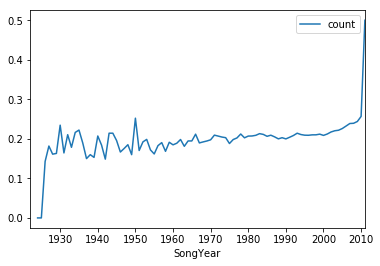

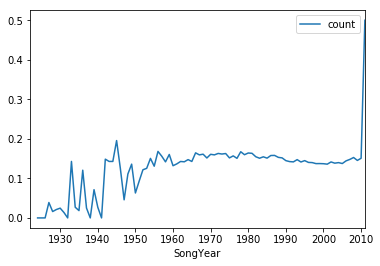

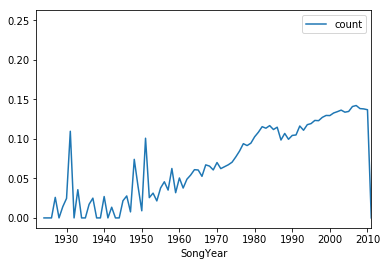

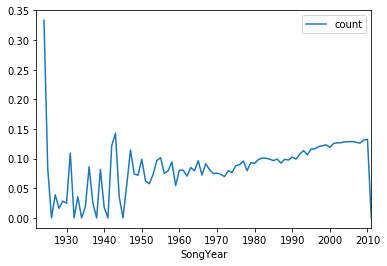

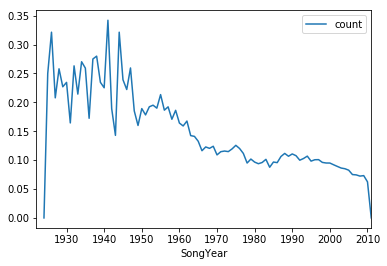

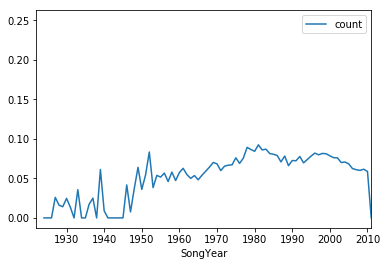

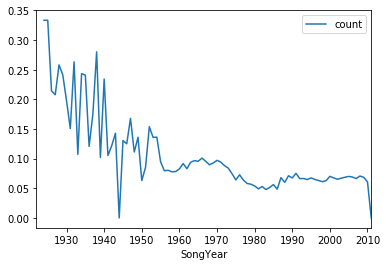

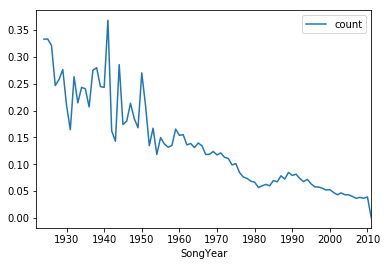

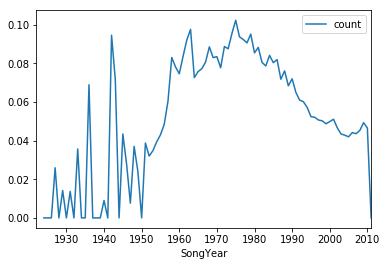

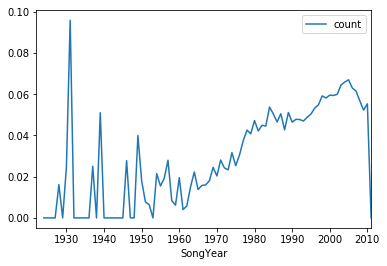

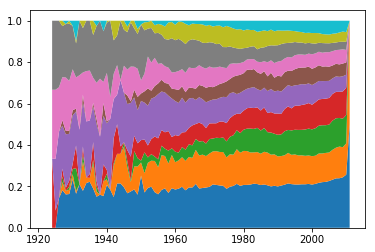

In [44]:
for year in range(1922,2012):
    for i in range(len(cnts)):
        if not cnts[i].index.contains(year):
            cnts[i].loc[year] = 0
            
songs_year_total = cnts[0].copy()
for i in range(1,len(cnts)):
    songs_year_total += cnts[i]

for i in range(len(cnts)):
    cnts[i] = cnts[i].sort_index() / songs_year_total

vals = []
for i in range(len(cnts)):
    vals.append(cnts[i].values.squeeze())
    cnts[i].plot(kind='line')
    plt.show()

plt.stackplot(range(1922,2012), *vals)

In [25]:
normalized_df.describe()

,ArtistLatitude,ArtistLongitude,ArtistHotness,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,num_songs,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence
count,82900.000000,82900.000000,229052.000000,229054.000000,229054.000000,229054.000000,153432.000000,229054.000000,229054.000000,229054.000000,229054.000000,229054.000000,229054.0,229054.000000,229054.000000,229054.000000
mean,39.963376,-54.527918,0.417123,243.353421,5.321033,-9.544769,0.432176,124.303870,1998.330957,0.446927,3.624840,0.519042,1.0,0.857651,2.013337,2.333793
std,15.622331,55.847716,0.109107,88.612165,3.596282,4.717646,0.214265,32.577068,10.990910,0.275339,1.180951,0.370034,0.0,0.123493,1.556545,2.333246
min,-51.800580,-159.540540,0.000000,60.002810,0.000000,-34.997000,0.000000,25.484000,1922.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,35.084180,-90.180490,0.364446,185.181590,2.000000,-12.027000,0.304977,99.202000,1994.000000,0.223000,4.000000,0.139000,1.0,0.808989,0.411000,0.331000
50%,40.714550,-75.162370,0.410247,230.295060,5.000000,-8.526000,0.459725,122.428000,2002.000000,0.466000,4.000000,0.560000,1.0,0.898876,2.084000,1.596000
75%,50.848380,-1.546580,0.470363,285.047710,9.000000,-6.087000,0.582751,144.657000,2006.000000,0.655000,4.000000,0.869000,1.0,0.943820,3.232000,3.839000
max,70.695760,175.471310,1.082503,599.979950,11.000000,3.634000,1.000000,219.999000,2011.000000,1.000000,7.000000,1.000000,1.0,1.000000,7.000000,11.000000


## Look at evolution of features for all songs

## SONGTEMPO

[ 115.1505  113.8395  117.2895  114.484   113.7555  116.4235  115.864
  115.8485  114.5555  116.579   122.217   122.15    121.838   122.658
  121.992   121.501   126.314   125.154   125.909   126.2675  128.947
  126.3235  125.572   124.045   123.319   122.482   121.998   119.975
  119.957   119.912   119.85    120.3275  119.8375  122.2455  122.253
  121.403   122.3495  122.6005  121.5775  121.712   122.202   122.127
  121.889   122.087   123.005   123.9495  124.057   124.8405  124.011
  124.984   143.005 ]


C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

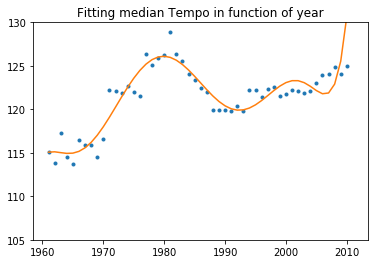

In [28]:
#MEDIAN
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))

g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting max Tempo in function of year')

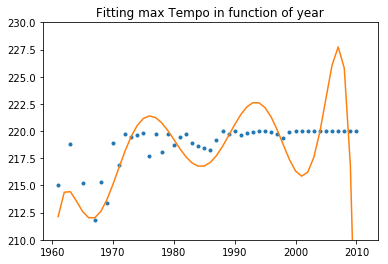

In [27]:
#MAX
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).max()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(210,230)
plt.title("Fitting max Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting min Tempo in function of year')

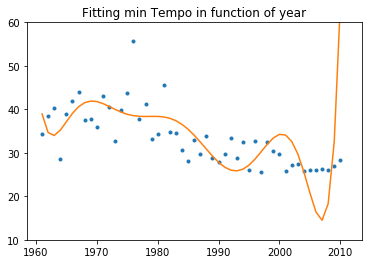

In [28]:
#MIN
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting min Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting difference max-min Tempo in function of year')

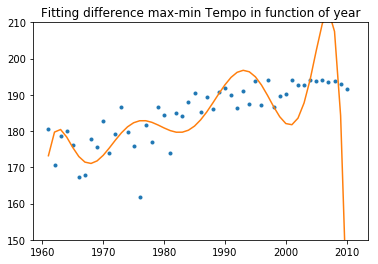

In [29]:
#MAX-MIN
t1 = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).max()
t2 = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t1.SongYear))
y = np.array(list(t1.SongTempo)) - np.array(list(t2.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 82))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(150,210)
plt.title("Fitting difference max-min Tempo in function of year")

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Wall time: 24min 15s


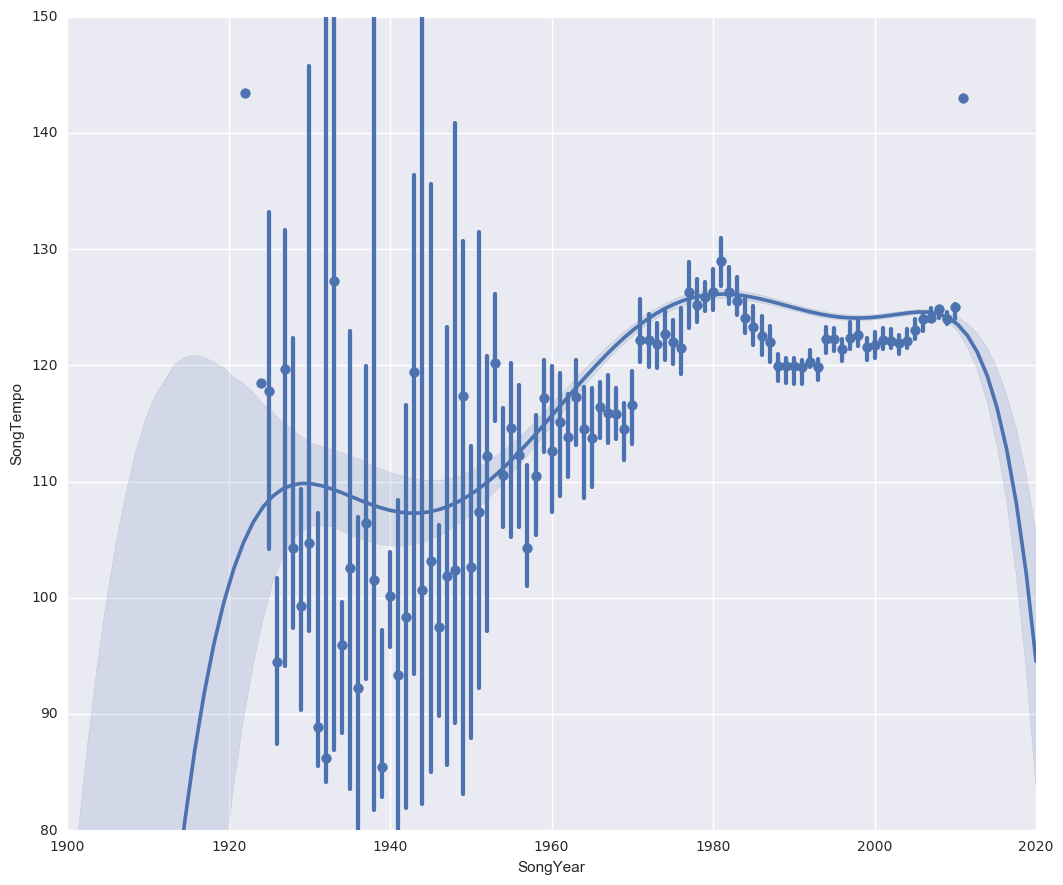

In [36]:
%%time
sns.set(color_codes=True)
g = sns.regplot('SongYear','SongTempo',normalized_df[['SongYear','SongTempo']],x_estimator=np.median,order=92)
g.set_ylim(80,150)
g.figure.set_size_inches(12.5, 10.5)
sns.despine()

## SONGDURATION

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(170, 245)

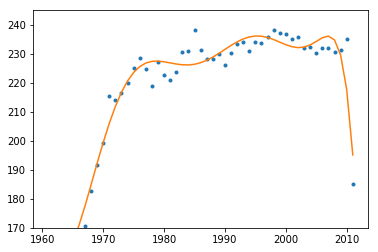

In [30]:
#MEDIAN
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','Duration']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.Duration))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(170,245)


C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


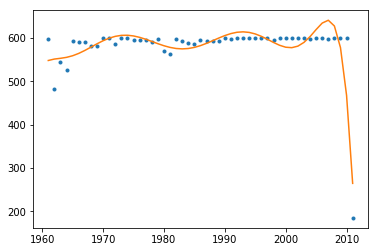

In [31]:
#MAX (not interesting here)
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','Duration']].groupby('SongYear',as_index=False).max()
x = np.array(list(t.SongYear))
y = np.array(list(t.Duration))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')


C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


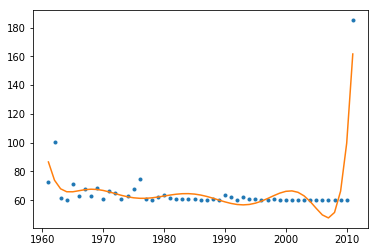

In [32]:
#MIN (not really interesting either)
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','Duration']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.Duration))
p100 = np.poly1d(np.polyfit(x, y, 50))
g = plt.plot(x, y, '.', x, p100(x), '-')


C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


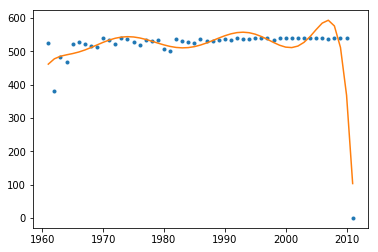

In [33]:
#MAX - MIN
t1 = normalized_df[normalized_df['SongYear']>1960][['SongYear','Duration']].groupby('SongYear',as_index=False).max()
t2 = normalized_df[normalized_df['SongYear']>1960][['SongYear','Duration']].groupby('SongYear',as_index=False).min()
x = np.array(list(t1.SongYear))
y = np.array(list(t1.Duration))-np.array(list(t2.Duration))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')

Thanks to Seaborn, we can plot a scatter with fitting linear regression, so that we can see how the MEAN ( can do min, max , std difference between both, etc ) evolve in function of the year
For the Tempo, we can see that in general the tempo from now is higher ( 10-20 BPM more ) than  before.

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Wall time: 24min 32s


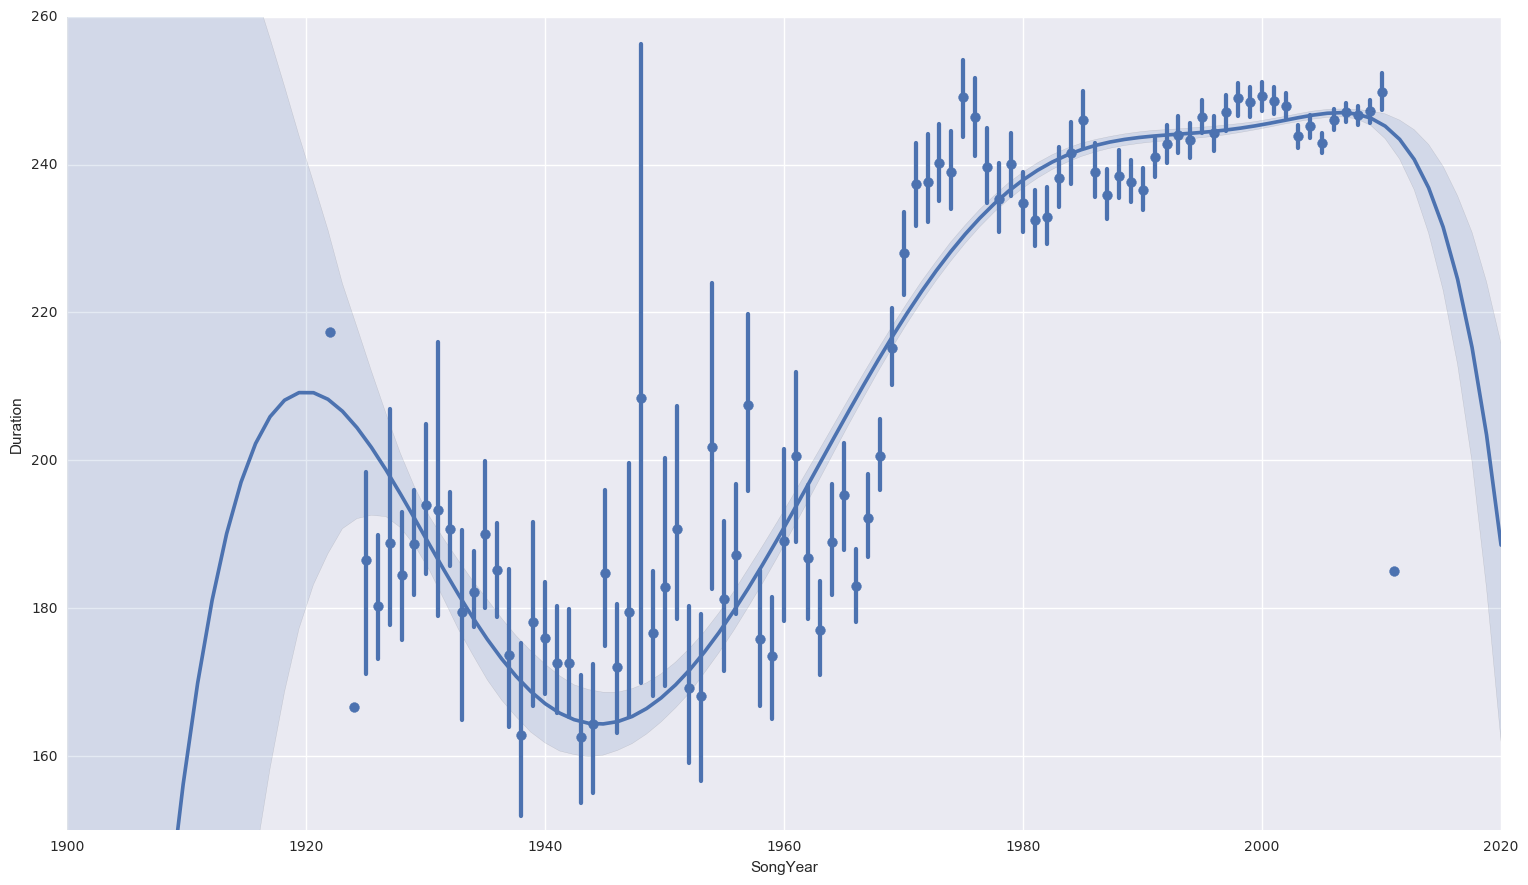

In [40]:
%%time
sns.set(color_codes=True)
g = sns.regplot('SongYear','Duration',normalized_df[['SongYear','Duration']],x_estimator=np.mean,order=92)
g.set_ylim(150,260)
g.figure.set_size_inches(18.5, 10.5)
sns.despine()

## SONGLOUDNESS

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(-15, -5)

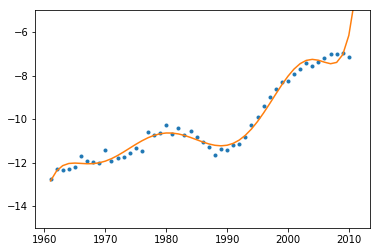

In [34]:
#MEDIAN
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongLoudness']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongLoudness))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(-15,-5)

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(-10, 5)

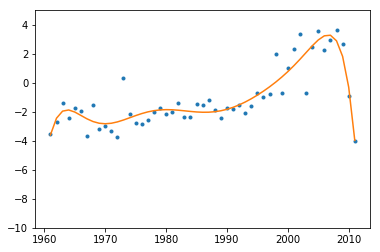

In [35]:
#MAX
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongLoudness']].groupby('SongYear',as_index=False).max()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongLoudness))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(-10,5)

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(-40, -25)

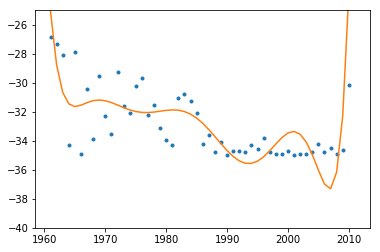

In [36]:
#MIN
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongLoudness']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongLoudness))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(-40,-25)

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(20, 45)

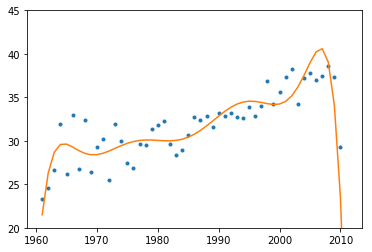

In [37]:
#MAX-MIN
t1 = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongLoudness']].groupby('SongYear',as_index=False).max()
t2 = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongLoudness']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t1.SongLoudness)) - np.array(list(t2.SongLoudness))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(20,45)

Wall time: 1min 58s


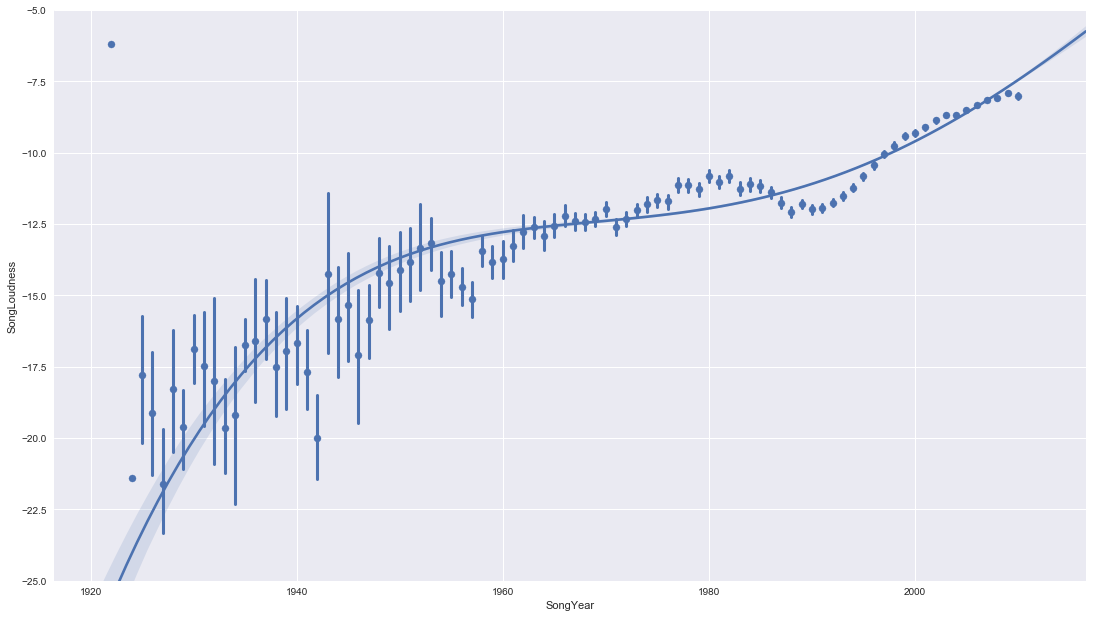

In [39]:
%%time
sns.set(color_codes=True)
g = sns.regplot('SongYear','SongLoudness',normalized_df[['SongYear','SongLoudness']],x_estimator=np.mean,order=6)
g.set_ylim(-25,-5)
g.figure.set_size_inches(18.5, 10.5)
sns.despine()

# SONGKEY

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(1, 2)

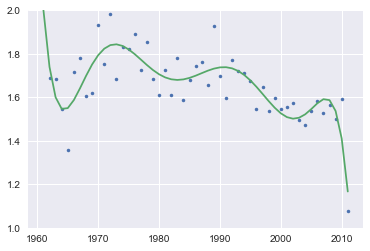

In [39]:
#Plotting songKey with confidence, no much meaning
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongKeyWithConfidence']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongKeyWithConfidence))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(1,2)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(4, 7)

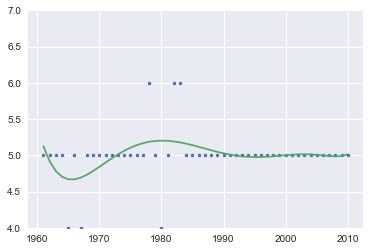

In [45]:
t = normalized_df[normalized_df['SongYear']>1960][normalized_df['SongKeyConfidence']>0.6][['SongYear','SongKey']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongKey))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(4,7)

In [48]:
#MAX and MIN are the same so no point

# SONGTIMESIGNATURE

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(0, 4)

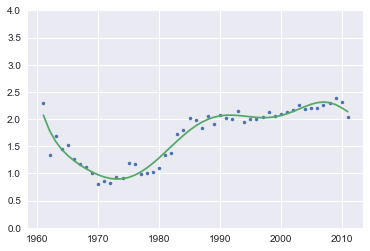

In [58]:
#Same does not mean much here
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTimeWithConfidence']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTimeWithConfidence))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(0,4)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


(2, 5)

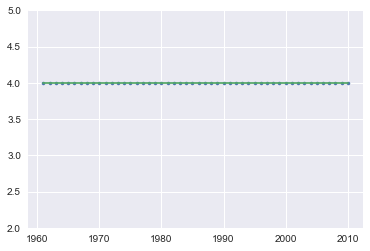

In [62]:
#Same does not mean much here
t = normalized_df[normalized_df['SongYear']>1960][normalized_df['SongTimeSignatureConfidence']>0.6][['SongYear','SongTimeSignature']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTimeSignature))
p100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, p100(x), '-')
plt.ylim(2,5)

# Feature analysis by Genre

Going to analyze features by genre

In [29]:
top_top_genres

['ROCK',
 'POP',
 'ELECTRONIC',
 'DOWNTEMPO',
 'JAZZ',
 'REGGAE',
 'FOLK',
 'BLUES',
 'R&B',
 'METAL']

In [36]:
%matplotlib notebook
def getTXYMean(col1):
    x =[]
    y = []
    for genre in top_top_genres:
        t = normalized_df.loc[set_genre_top[genre]][normalized_df['SongYear']>1960][['SongYear',col1]].groupby('SongYear',as_index=False).median()
        x.append(np.array(list(t['SongYear'])))
        y.append(np.array(list(t[col1])))
    return x,y

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<IPython.core.display.Javascript object>


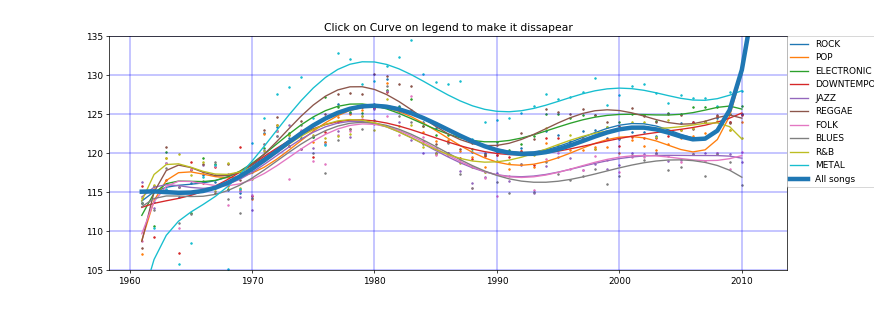

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


8

In [51]:
#MEAN tempo all genre vs Mean Tempo

genre = top_top_genres
x,y = getTXYMean('SongTempo')
fig, ax = plt.subplots()
l = []
for group in range(0,len(y)):
    fit = np.polyfit(x[group], y[group], 92)
    fit_fn = np.poly1d(fit)
    ax.set_ylim(105,135)
    ax.scatter(x[group],y[group],s=3)
    line, = ax.plot(x[group], fit_fn(x[group]), '-',linewidth=1.5,label=top_top_genres[group])
    l.append(line)
    
t = normalized_df[normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x= (np.array(list(t['SongYear'])))
y = (np.array(list(t['SongTempo'])))
fit = np.polyfit(x, y, 92)
fit_fn = np.poly1d(fit)
g = plt.plot(x, fit_fn(x), '-',linewidth=5,label='All songs')
ax.grid(color='b', linestyle='-', linewidth=0.5)
leg = ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
fig.set_size_inches(5,5)
ax.set_title('Click on Curve on legend to make it dissapear')

lined = dict()
for legline, origline in zip(leg.get_lines(), l):
    legline.set_picker(5)  # 5 pts tolerance
    lined[legline] = origline


def onpick(event):
    # on the pick event, find the orig line corresponding to the
    # legend proxy line, and toggle the visibility
    legline = event.artist
    origline = lined[legline]
    vis = not origline.get_visible()
    origline.set_visible(vis)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled
    if vis:
        legline.set_alpha(1.0)
    else:
        legline.set_alpha(0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', onpick)




## MEAN TEMPO

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

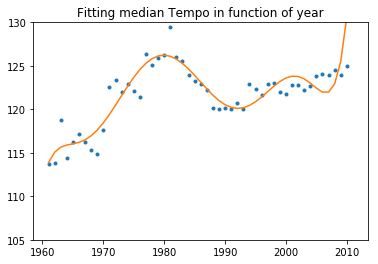

In [43]:
#Mean ROCK
t = normalized_df.loc[set_genre_top['ROCK']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

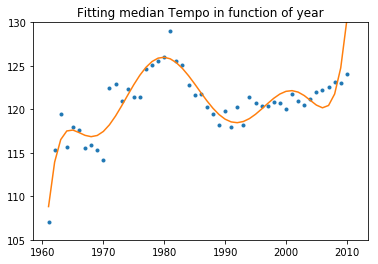

In [44]:
#Mean POP
t = normalized_df.loc[set_genre_top['POP']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

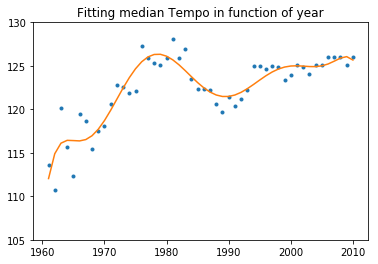

In [45]:
#Mean ELECTRONIC (interesting did not have the little up& down between 80s-2000s)
t = normalized_df.loc[set_genre_top['ELECTRONIC']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

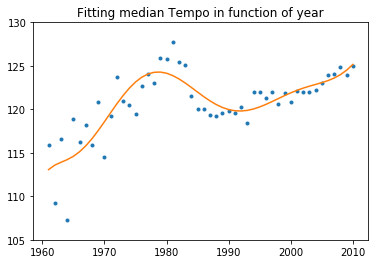

In [46]:
#Mean DOWNTEMPO (interesting too)
t = normalized_df.loc[set_genre_top['DOWNTEMPO']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

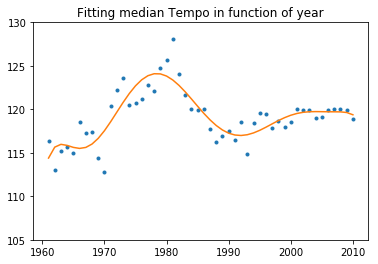

In [47]:
#Mean JAZZ (can be interesting too)
t = normalized_df.loc[set_genre_top['JAZZ']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

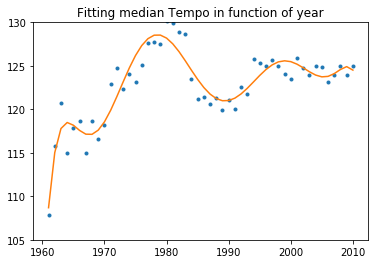

In [48]:
#Mean REGGAE
t = normalized_df.loc[set_genre_top['REGGAE']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

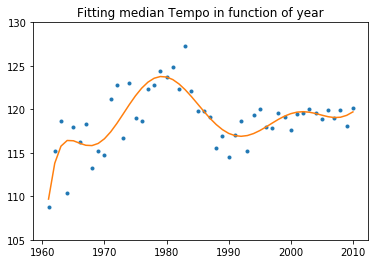

In [49]:
#Mean FOLK
t = normalized_df.loc[set_genre_top['FOLK']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

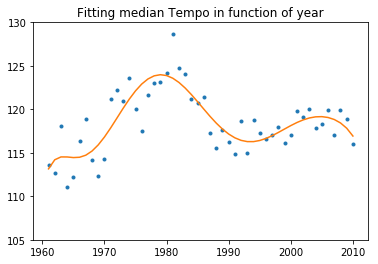

In [50]:
#Mean BLUES (interesting)
t = normalized_df.loc[set_genre_top['BLUES']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

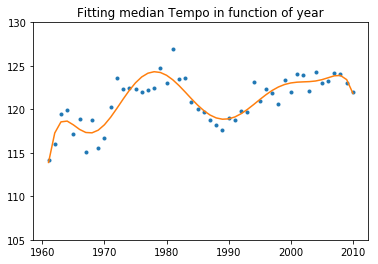

In [51]:
#Mean R&B (interesting)
t = normalized_df.loc[set_genre_top['R&B']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,130)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

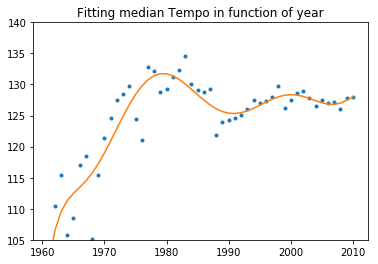

In [52]:
#Mean METAL (really interesting)
t = normalized_df.loc[set_genre_top['METAL']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).median()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(105,140)
plt.title("Fitting median Tempo in function of year")

# MIN TEMPO

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

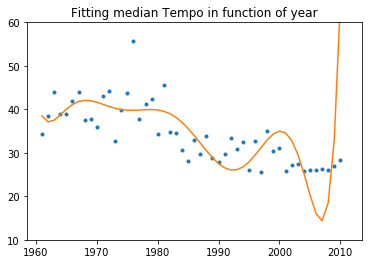

In [89]:
#Min ROCK
t = normalized_df.loc[set_genre_top['ROCK']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

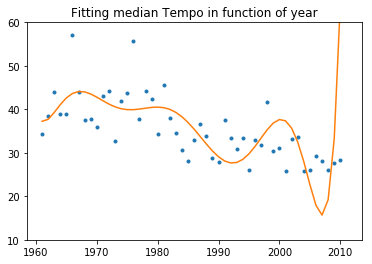

In [90]:
#Min POP
t = normalized_df.loc[set_genre_top['POP']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

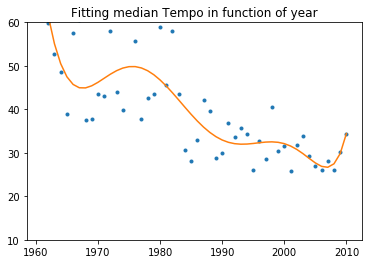

In [92]:
#Min ELECTRONIC (interesting)
t = normalized_df.loc[set_genre_top['ELECTRONIC']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

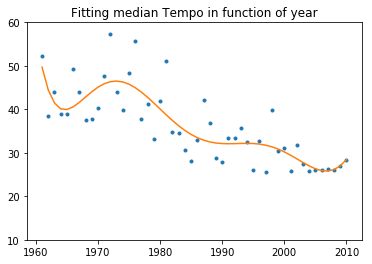

In [94]:
#Min DOWNTEMPO (interesting)
t = normalized_df.loc[set_genre_top['DOWNTEMPO']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

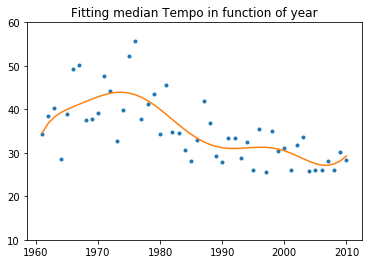

In [95]:
#Min JAZZ (interesting)
t = normalized_df.loc[set_genre_top['JAZZ']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

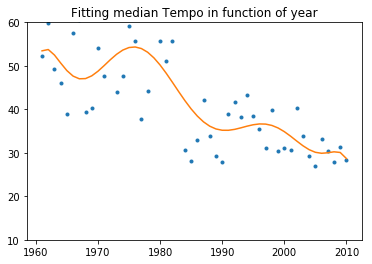

In [96]:
#Min REGGAE (interesting)
t = normalized_df.loc[set_genre_top['REGGAE']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

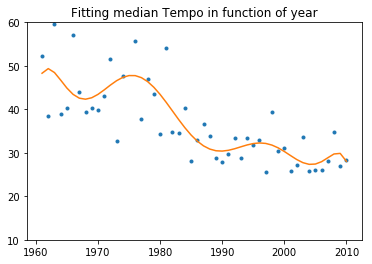

In [97]:
#Min FOLK(interesting)
t = normalized_df.loc[set_genre_top['FOLK']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

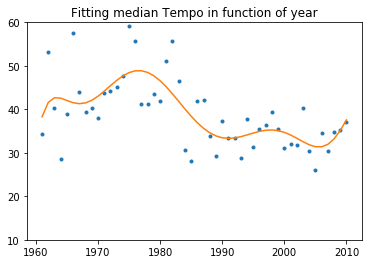

In [98]:
#Min BLUES (interesting)
t = normalized_df.loc[set_genre_top['BLUES']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

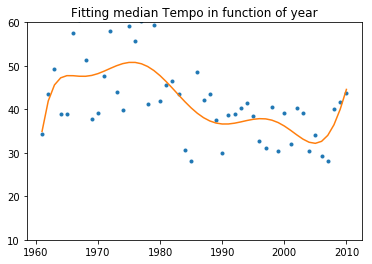

In [99]:
#Min R&B(interesting)
t = normalized_df.loc[set_genre_top['R&B']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))


Text(0.5,1,'Fitting median Tempo in function of year')

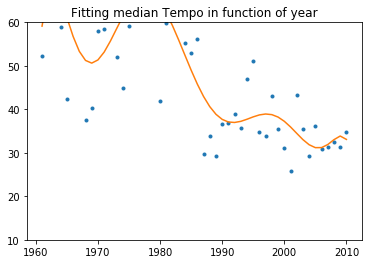

In [100]:
#Min METAL (relly interesting)
t = normalized_df.loc[set_genre_top['METAL']][normalized_df['SongYear']>1960][['SongYear','SongTempo']].groupby('SongYear',as_index=False).min()
x = np.array(list(t.SongYear))
y = np.array(list(t.SongTempo))
ptempo100 = np.poly1d(np.polyfit(x, y, 92))
g = plt.plot(x, y, '.', x, ptempo100(x), '-')
plt.ylim(10,60)
plt.title("Fitting median Tempo in function of year")

## Train classifier for genre on recent songs.

#### Drop some of the junk variables (id, song_id, ...)¶

In [53]:
df_knn = normalized_df[normalized_df['SongYear']>2000]
df_knn.head()

,SongTitle,ArtistID,ArtistName,ArtistLatitude,ArtistLongitude,ArtistMbtags,ArtistTerms,ArtistHotness,Duration,SongKey,...,SongTimeSignatureConfidence,ArtistLocation,ArtistTermFreq,ArtistTermWeight,num_songs,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence,ParentGenres,TopGenres
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAAAK128F9318786,Scream,ARJNIUY12298900C91,Adelitas Way,NaN,NaN,[],"[alternative metal, heavy metal, rock, alterna...",0.461318,213.94240,1,...,0.846,,"[[0.995874657423, 0.995874657423, 1.0, 0.88565...","[1.0, 0.899353739319, 0.756187682886, 0.713117...",1,0.977528,3.384,0.349,"[CONTEMPORARY ROCK, ALTERNATIVE ROCK / INDIE]",[ROCK]
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,AR73AIO1187B9AD57B,Western Addiction,37.77916,-122.42005,[],"[melodic hardcore, skate punk, hardcore punk, ...",0.386606,118.07302,7,...,0.546,San Francisco; CA,"[[0.958442007525, 0.877423051563, 1.0, 0.82014...","[1.0, 0.968559809446, 0.964753894876, 0.869181...",1,0.932584,2.184,1.309,"[HARDCORE PUNK, JAMAICAN (MUSIC) / REGGAE, HAR...","[ROCK, REGGAE, ELECTRONIC]"
TRAAAYL128F4271A5B,Indian Angel,ARY589G1187B9A9F4E,Talkdemonic,45.51179,-122.67563,[],"[instrumental rock, trip hop, post rock, exper...",0.401116,171.57179,4,...,0.487,Portland; OR,"[[0.937765215693, 0.935586176467, 0.9529592228...","[1.0, 0.976454544216, 0.956097776921, 0.943573...",1,0.921348,0.487,0.416,"[DOWNTEMPO / AMBIENT, PUNK ROCK / NEW WAVE, CO...","[DOWNTEMPO, ROCK, ELECTRONIC, POP, FOLK]"
TRAAADT12903CCC339,Andalucia,ARNZW6T1187B989D0F,Stanley Black,51.50632,-0.12714,"[uk, british, english, production music]","[easy listening, exotica, jazz, space age pop,...",0.336660,160.73098,2,...,0.774,London,"[[0.973150276847, 0.860320416385, 1.0, 0.78330...","[1.0, 0.98287226378, 0.921440653082, 0.9188920...",1,0.910112,2.322,0.030,"[DOWNTEMPO / AMBIENT, JAZZ, RHYTHM N BLUES (R&...","[DOWNTEMPO, JAZZ, R&B, BLUES, ROCK, POP, ELECT..."
TRAAAEA128F935A30D,I'll Slap Your Face (Entertainment USA Theme),ARSVTNL1187B992A91,Jonathan King,51.50632,-0.12714,[],"[comedy rock, pop rock, disco, chicago blues, ...",0.000000,129.85424,5,...,0.000,London; England,"[[0.958213861832, 1.0, 0.898218005468, 0.79725...","[1.0, 0.951721007342, 0.882993699055, 0.872997...",1,0.887640,0.000,0.420,"[RHYTHM N BLUES (R&B), BLUES, GOLDEN AGE / CLA...","[R&B, BLUES, ROCK, POP, REGGAE, JAZZ]"


In [54]:
df_knn.select_dtypes(include=['object']).columns

Index(['SongTitle', 'ArtistID', 'ArtistName', 'ArtistMbtags', 'ArtistTerms',
       'ArtistLocation', 'ArtistTermFreq', 'ArtistTermWeight', 'ParentGenres',
       'TopGenres'],
      dtype='object')

In [55]:
#Drop the array for the moment
df_knn = df_knn.drop('ArtistTerms',1,inplace=False)
df_knn = df_knn.drop('ArtistMbtags',1,inplace=False)
df_knn = df_knn.drop('ArtistTermFreq',1,inplace=False)
df_knn = df_knn.drop('ArtistTermWeight',1,inplace=False)
df_knn = df_knn.drop('num_songs',1,inplace=False)

In [56]:
df_knn = df_knn.drop('ArtistID',1,inplace=False)

df_knn.head()

,SongTitle,ArtistName,ArtistLatitude,ArtistLongitude,ArtistHotness,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence,ParentGenres,TopGenres
track_id,,,,,,,,,,,,,,,,,,,,
TRAAAAK128F9318786,Scream,Adelitas Way,NaN,NaN,0.461318,213.94240,1,-4.769,0.733372,99.944,2009,0.349,4,0.846,,0.977528,3.384,0.349,"[CONTEMPORARY ROCK, ALTERNATIVE ROCK / INDIE]",[ROCK]
TRAAAAV128F421A322,A Poor Recipe For Civic Cohesion,Western Addiction,37.77916,-122.42005,0.386606,118.07302,7,-7.240,0.481694,125.475,2005,0.187,4,0.546,San Francisco; CA,0.932584,2.184,1.309,"[HARDCORE PUNK, JAMAICAN (MUSIC) / REGGAE, HAR...","[ROCK, REGGAE, ELECTRONIC]"
TRAAAYL128F4271A5B,Indian Angel,Talkdemonic,45.51179,-122.67563,0.401116,171.57179,4,-14.015,0.614752,127.503,2004,0.104,1,0.487,Portland; OR,0.921348,0.487,0.416,"[DOWNTEMPO / AMBIENT, PUNK ROCK / NEW WAVE, CO...","[DOWNTEMPO, ROCK, ELECTRONIC, POP, FOLK]"
TRAAADT12903CCC339,Andalucia,Stanley Black,51.50632,-0.12714,0.336660,160.73098,2,-14.567,0.000000,97.623,2003,0.015,3,0.774,London,0.910112,2.322,0.030,"[DOWNTEMPO / AMBIENT, JAZZ, RHYTHM N BLUES (R&...","[DOWNTEMPO, JAZZ, R&B, BLUES, ROCK, POP, ELECT..."
TRAAAEA128F935A30D,I'll Slap Your Face (Entertainment USA Theme),Jonathan King,51.50632,-0.12714,0.000000,129.85424,5,-9.495,0.000000,156.677,2001,0.084,4,0.000,London; England,0.887640,0.000,0.420,"[RHYTHM N BLUES (R&B), BLUES, GOLDEN AGE / CLA...","[R&B, BLUES, ROCK, POP, REGGAE, JAZZ]"


In [57]:
for col in df_knn.columns:
    if(col!='ParentGenres' and col!='TopGenres'):
        print ("Column {} has {} unique instances".format( col, len(df_knn[col].unique())) )

Column SongTitle has 106732 unique instances
Column ArtistName has 22323 unique instances
Column ArtistLatitude has 1652 unique instances
Column ArtistLongitude has 1652 unique instances
Column ArtistHotness has 19839 unique instances
Column Duration has 17223 unique instances
Column SongKey has 12 unique instances
Column SongLoudness has 19668 unique instances
Column SongHotness has 24179 unique instances
Column SongTempo has 67798 unique instances
Column SongYear has 11 unique instances
Column SongKeyConfidence has 1001 unique instances
Column SongTimeSignature has 5 unique instances
Column SongTimeSignatureConfidence has 1001 unique instances
Column ArtistLocation has 3152 unique instances
Column SongYearNorm has 11 unique instances
Column SongTimeWithConfidence has 3809 unique instances
Column SongKeyWithConfidence has 6521 unique instances


Observation : Maybe round the Duration,Tempo and Loudness

In [58]:
df_knn.Duration = df_knn.Duration.apply(lambda x: math.floor(x))
df_knn.SongTempo = df_knn.SongTempo.apply(lambda x: math.floor(x))
df_knn.SongLoudness = df_knn.SongLoudness.apply(lambda x: math.floor(x))
for col in df_knn.columns:
    if(col!='ParentGenres' and col!='TopGenres'):
        print ("Column {} has {} unique instances".format( col, len(df_knn[col].unique())) )

Column SongTitle has 106732 unique instances
Column ArtistName has 22323 unique instances
Column ArtistLatitude has 1652 unique instances
Column ArtistLongitude has 1652 unique instances
Column ArtistHotness has 19839 unique instances
Column Duration has 540 unique instances
Column SongKey has 12 unique instances
Column SongLoudness has 39 unique instances
Column SongHotness has 24179 unique instances
Column SongTempo has 195 unique instances
Column SongYear has 11 unique instances
Column SongKeyConfidence has 1001 unique instances
Column SongTimeSignature has 5 unique instances
Column SongTimeSignatureConfidence has 1001 unique instances
Column ArtistLocation has 3152 unique instances
Column SongYearNorm has 11 unique instances
Column SongTimeWithConfidence has 3809 unique instances
Column SongKeyWithConfidence has 6521 unique instances


In [59]:
def categorize_hotness(x) :
    if(x<0.10) :
        return 0
    elif(0.1<=x<0.2):
        return 1
    elif(0.2<=x<0.3):
        return 2
    elif(0.3<=x<0.4):
        return 3
    elif(0.4<=x<0.5):
        return 4
    elif(0.5<=x<0.6):
        return 5
    elif(0.6<=x<0.7):
        return 6
    elif(0.7<=x<0.8):
        return 7
    elif(0.8<=x<0.9):
        return 8
    else:
        return 9

In [60]:
def numerize_parentGenre(x):
    sumR = 0
    for g in x:
        sumR += list(set_genre_parent_num.keys()).index(g)
    return sumR

In [61]:
def categorize_genre(x):
    if not x:
        return -1
    else :
        return list(set_genre_top_num.keys()).index(x[0])

In [62]:
df_knn['label'] = df_knn.TopGenres.apply(lambda x : categorize_genre(x))
df_knn['ParentGenres'] = df_knn.ParentGenres.apply(lambda x : numerize_parentGenre(x))

In [63]:
df_knn._get_numeric_data().columns

Index(['ArtistLatitude', 'ArtistLongitude', 'ArtistHotness', 'Duration',
       'SongKey', 'SongLoudness', 'SongHotness', 'SongTempo', 'SongYear',
       'SongKeyConfidence', 'SongTimeSignature', 'SongTimeSignatureConfidence',
       'SongYearNorm', 'SongTimeWithConfidence', 'SongKeyWithConfidence',
       'ParentGenres', 'label'],
      dtype='object')

## Begin classification

In [72]:
#Choose the X, Y value

X = df_knn.drop("label", axis=1, inplace = False)
X = X.drop("TopGenres", axis=1, inplace = False)
X = X.drop("ArtistName", axis=1, inplace = False)
X = X.drop("SongTitle", axis=1, inplace = False)
X = X.drop("ArtistLocation", axis=1, inplace = False)
y = df_knn.label
X


,ArtistLatitude,ArtistLongitude,ArtistHotness,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence,ParentGenres
track_id,,,,,,,,,,,,,,,,
TRAAAAK128F9318786,NaN,NaN,0.461318,213,1,-5,0.733372,99,2009,0.349,4,0.846,0.977528,3.384,0.349,15
TRAAAAV128F421A322,37.77916,-122.42005,0.386606,118,7,-8,0.481694,125,2005,0.187,4,0.546,0.932584,2.184,1.309,16
TRAAAYL128F4271A5B,45.51179,-122.67563,0.401116,171,4,-15,0.614752,127,2004,0.104,1,0.487,0.921348,0.487,0.416,78
TRAAADT12903CCC339,51.50632,-0.12714,0.336660,160,2,-15,0.000000,97,2003,0.015,3,0.774,0.910112,2.322,0.030,102
TRAAAEA128F935A30D,51.50632,-0.12714,0.000000,129,5,-10,0.000000,156,2001,0.084,4,0.000,0.887640,0.000,0.420,78
TRAAAEM128F93347B9,NaN,NaN,0.342480,580,11,-11,0.468998,91,2004,0.381,3,1.000,0.921348,3.000,4.191,83
TRAAAFD128F92F423A,NaN,NaN,0.401724,209,2,-5,0.604501,129,2007,0.092,4,0.562,0.955056,2.248,0.184,97
TRAAAGF12903CEC202,NaN,NaN,0.409770,183,5,-23,NaN,96,2005,0.888,4,1.000,0.932584,4.000,4.440,40
TRAAAGR128F425B14B,NaN,NaN,0.559257,240,9,-8,NaN,123,2008,0.608,4,0.800,0.966292,3.200,5.472,21


In [73]:
# For the other than numeric value, isolate them

def model_matrix(df , columns):
    dummified_cols = pd.get_dummies(df[columns])
    df = df.drop(columns, axis = 1, inplace=False)
    df_new = df.join(dummified_cols)
    return df_new

#X = model_matrix(X, [ 'ArtistName'])

X.head()

,ArtistLatitude,ArtistLongitude,ArtistHotness,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence,ParentGenres
track_id,,,,,,,,,,,,,,,,
TRAAAAK128F9318786,NaN,NaN,0.461318,213,1,-5,0.733372,99,2009,0.349,4,0.846,0.977528,3.384,0.349,15
TRAAAAV128F421A322,37.77916,-122.42005,0.386606,118,7,-8,0.481694,125,2005,0.187,4,0.546,0.932584,2.184,1.309,16
TRAAAYL128F4271A5B,45.51179,-122.67563,0.401116,171,4,-15,0.614752,127,2004,0.104,1,0.487,0.921348,0.487,0.416,78
TRAAADT12903CCC339,51.50632,-0.12714,0.336660,160,2,-15,0.000000,97,2003,0.015,3,0.774,0.910112,2.322,0.030,102
TRAAAEA128F935A30D,51.50632,-0.12714,0.000000,129,5,-10,0.000000,156,2001,0.084,4,0.000,0.887640,0.000,0.420,78


In [74]:
X2 = X.fillna(value = 0)
X2

,ArtistLatitude,ArtistLongitude,ArtistHotness,Duration,SongKey,SongLoudness,SongHotness,SongTempo,SongYear,SongKeyConfidence,SongTimeSignature,SongTimeSignatureConfidence,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence,ParentGenres
track_id,,,,,,,,,,,,,,,,
TRAAAAK128F9318786,0.00000,0.00000,0.461318,213,1,-5,0.733372,99,2009,0.349,4,0.846,0.977528,3.384,0.349,15
TRAAAAV128F421A322,37.77916,-122.42005,0.386606,118,7,-8,0.481694,125,2005,0.187,4,0.546,0.932584,2.184,1.309,16
TRAAAYL128F4271A5B,45.51179,-122.67563,0.401116,171,4,-15,0.614752,127,2004,0.104,1,0.487,0.921348,0.487,0.416,78
TRAAADT12903CCC339,51.50632,-0.12714,0.336660,160,2,-15,0.000000,97,2003,0.015,3,0.774,0.910112,2.322,0.030,102
TRAAAEA128F935A30D,51.50632,-0.12714,0.000000,129,5,-10,0.000000,156,2001,0.084,4,0.000,0.887640,0.000,0.420,78
TRAAAEM128F93347B9,0.00000,0.00000,0.342480,580,11,-11,0.468998,91,2004,0.381,3,1.000,0.921348,3.000,4.191,83
TRAAAFD128F92F423A,0.00000,0.00000,0.401724,209,2,-5,0.604501,129,2007,0.092,4,0.562,0.955056,2.248,0.184,97
TRAAAGF12903CEC202,0.00000,0.00000,0.409770,183,5,-23,0.000000,96,2005,0.888,4,1.000,0.932584,4.000,4.440,40
TRAAAGR128F425B14B,0.00000,0.00000,0.559257,240,9,-8,0.000000,123,2008,0.608,4,0.800,0.966292,3.200,5.472,21


In [75]:
X2.columns

Index(['ArtistLatitude', 'ArtistLongitude', 'ArtistHotness', 'Duration',
       'SongKey', 'SongLoudness', 'SongHotness', 'SongTempo', 'SongYear',
       'SongKeyConfidence', 'SongTimeSignature', 'SongTimeSignatureConfidence',
       'SongYearNorm', 'SongTimeWithConfidence', 'SongKeyWithConfidence',
       'ParentGenres'],
      dtype='object')

In [76]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()

X2[['ArtistLatitude', 'ArtistLongitude', 'ArtistHotness', 'Duration',
       'SongKey', 'SongLoudness', 'SongHotness', 'SongTempo', 'SongYear',
       'SongKeyConfidence', 'SongTimeSignature', 'SongTimeSignatureConfidence',
       'SongYearNorm', 'SongTimeWithConfidence', 'SongKeyWithConfidence',
       'ParentGenres']] = Scaler.fit_transform(X2[['ArtistLatitude', 'ArtistLongitude', 'ArtistHotness', 'Duration',
       'SongKey', 'SongLoudness', 'SongHotness', 'SongTempo', 'SongYear',
       'SongKeyConfidence', 'SongTimeSignature', 'SongTimeSignatureConfidence',
       'SongYearNorm', 'SongTimeWithConfidence', 'SongKeyWithConfidence',
       'ParentGenres']])

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

In [78]:
data_knn = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')
data_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [79]:
data_knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [80]:
data_knn.predict(x_test)

array([9, 9, 0, ..., 7, 0, 2], dtype=int64)

In [81]:
# R-square from training and test data
rsquared_train = data_knn.score(x_train, y_train)
rsquared_test = data_knn.score(x_test, y_test)
print ('Training data R-squared:')
print(rsquared_train)
print ('Test data R-squared:')
print(rsquared_test)

Training data R-squared:
0.45144538012
Test data R-squared:
0.344910390067
